In [1]:
import datetime

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline
sns.set()

In [2]:
from covid_tracking_data.collector import *
from covid_analysis.utility import *
from covid_analysis.models import *
from ourworldindata_org.collector import get_dataset_df_from_file as get_world_dataset_df_from_file

In [3]:
 from matplotlib.axes._axes import _log as matplotlib_axes_logger
 matplotlib_axes_logger.setLevel('ERROR')

### Fetch the latest data

If the interface is overloaded, the collector will retry every few seconds.

In [4]:
df, states_in_order = get_dataset_df()
fns = save_data(df, states_in_order)
print("data saved to {} and {}".format(*fns))

           positive       negative       pending  hospitalizedCurrently  \
count   1535.000000    1395.000000    460.000000              89.000000   
mean     980.012378    5425.248746   1316.284783            1027.853933   
std     5178.362220   12691.851108   8225.007195            2735.396533   
min        0.000000       0.000000     -3.000000               2.000000   
25%        7.000000      95.000000      4.000000              31.000000   
50%       63.000000     764.000000     20.000000              60.000000   
75%      392.000000    4716.500000     95.500000             246.000000   
max    92381.000000  146584.000000  64400.000000           13383.000000   

       hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
count              389.000000       27.000000        54.000000   
mean               492.308483      822.444444       370.185185   
std               2010.737244     1058.136582       727.796781   
min                  0.000000        9.000000         2.0000

### Fetch data set from local disk

In [5]:
!ls ~/data/
# gets thte latest file names
recent = ! ls -drt ~/data/* | tail -n 2
print("Latest files are:\n\t{}\n\t{}".format(*recent))

2020-04-01_1652_state_daily_data.csv 2020-04-01_1658_state_rank.csv
2020-04-01_1652_state_rank.csv       2020-04-03_0323_state_daily_data.csv
2020-04-01_1654_state_daily_data.csv 2020-04-03_0323_state_rank.csv
2020-04-01_1654_state_rank.csv       2020-04-03_0345_state_daily_data.csv
2020-04-01_1658_state_daily_data.csv 2020-04-03_0345_state_rank.csv
Latest files are:
	/Users/drskippy/data/2020-04-03_0345_state_daily_data.csv
	/Users/drskippy/data/2020-04-03_0345_state_rank.csv


In [6]:
df, states_in_order = get_dataset_df_from_file(recent)
df.head()

date state  positive  negative  pending  hospitalizedCurrently  \
0 2020-03-04    NY       6.0      48.0     24.0                    NaN   
1 2020-03-05    NY      22.0      76.0     24.0                    NaN   
2 2020-03-06    NY      33.0      92.0    236.0                    NaN   
3 2020-03-07    NY      76.0      92.0    236.0                    NaN   
4 2020-03-08    NY     105.0      92.0      NaN                    NaN   

   hospitalizedCumulative  inIcuCurrently  inIcuCumulative  \
0                     NaN             NaN              NaN   
1                     NaN             NaN              NaN   
2                     NaN             NaN              NaN   
3                     NaN             NaN              NaN   
4                     NaN             NaN              NaN   

   onVentilatorCurrently  ...  totalTestResults  posNeg fips deathIncrease  \
0                    NaN  ...                54      54   36           NaN   
1                    NaN  ...                98      98   36           0.0   
2                    NaN  ...               125     125   36           0.0   
3                    NaN  ...               168     168   36           0.0   
4                    NaN  ...               197     197   36           0.0   

   hospitalizedIncrease  negativeIncrease  positiveIncrease  \
0                   NaN               NaN               NaN   
1                   0.0              28.0              16.0   
2                   0.0              16.0              11.0   
3                   0.0               0.0              43.0   
4                   0.0               0.0              29.0   

   totalTestResultsIncrease  order        lastUpdateEt  
0                       NaN      0 2020-04-02 11:45:00  
1                      44.0      0 2020-04-02 11:45:00  
2                      27.0      0 2020-04-02 11:45:00  
3                      43.0      0 2020-04-02 11:45:00  
4                      29.0      0 2020-04-02 11:45:00  

[5 rows x 27 columns]

In [7]:
dfus, _ = get_state_df(df, "*")
dfus["sum_of_tests"] = dfus["positive"] + dfus["negative"] + dfus["pending"]
dfus.tail()

date  positive   negative  pending  totalTestResults   death  \
25 2020-03-29  139061.0   692290.0  65549.0            831351  2428.0   
26 2020-03-30  160530.0   784324.0  65382.0            944854  2939.0   
27 2020-03-31  184683.0   864201.0  59529.0           1048884  3746.0   
28 2020-04-01  210770.0   939190.0  59687.0           1149960  4700.0   
29 2020-04-02  239009.0  1028649.0  62119.0           1267658  5784.0   

          lastUpdateEt  daily_new_positive  sum_of_tests  
25 2020-04-02 16:45:00             20827.0      896900.0  
26 2020-04-02 16:45:00             21469.0     1010236.0  
27 2020-04-02 16:45:00             24153.0     1108413.0  
28 2020-04-02 16:45:00             26087.0     1209647.0  
29 2020-04-02 16:45:00             28239.0     1329777.0

### Zero-day normalized log plots

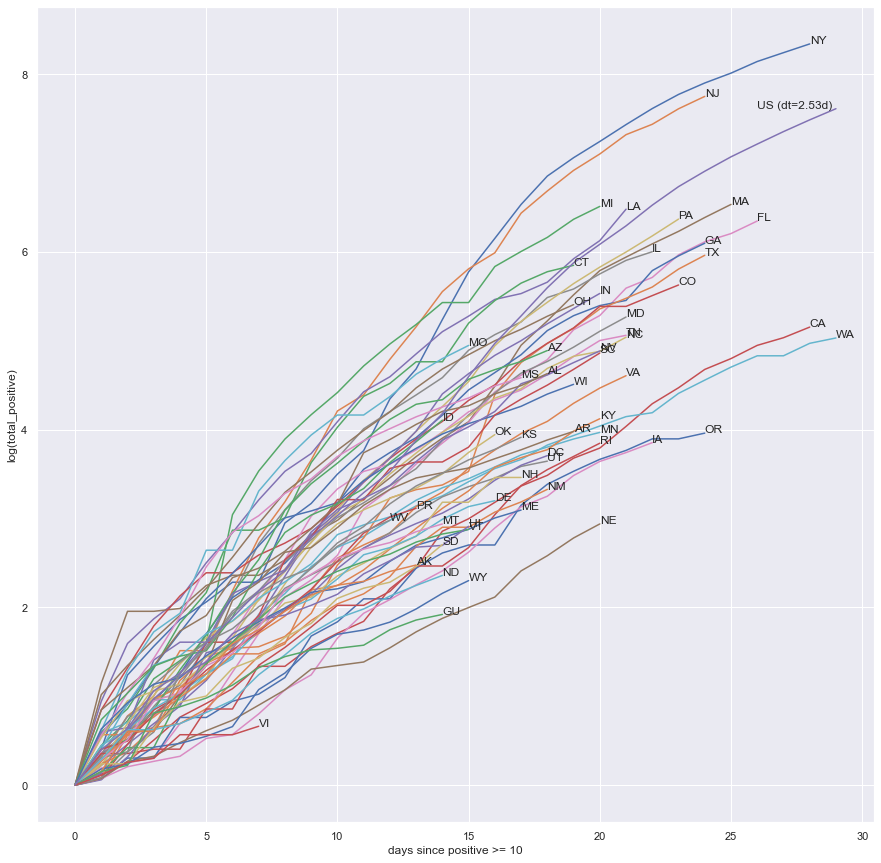

In [8]:
# start after day with min_pos or more cases
min_pos = 10
last_n_days = None

# image
plt.figure(figsize=[15,15])

key_value = "days_since_{}".format(min_pos)

# state by state
for s in states_in_order:
    try:
        dfq, dt, lud = get_state_doubling_df(df, s, zero_aligned=True, min_pos=min_pos, use_last_n_days=last_n_days)
        plt.plot(dfq[key_value].values, dfq.log_positive.values)
        plt.annotate(s, (dfq[key_value].values[-1], dfq.log_positive.values[-1]))
    except IndexError:
        pass

# All US image
try:
    dfq, dt, lud = get_state_doubling_df(df, "*", zero_aligned=True, min_pos=min_pos, use_last_n_days=last_n_days)
    plt.plot(dfq[key_value].values, dfq.log_positive.values)
    xus = int(.9* dfq[key_value].values[-1])
    plt.annotate("US (dt={:1.2f}d)".format(dt), (xus , dfq.log_positive.values[-1]))
except IndexError:
    pass

plt.xlabel("days since positive >= {}".format(min_pos))
plt.ylabel("log(total_positive)")
plt.show()

### US Totals and Doubling Times

US Total Positive, doubling every 4.11 days
  as of 2020-04-02T16:45
  based on last 10 days of data


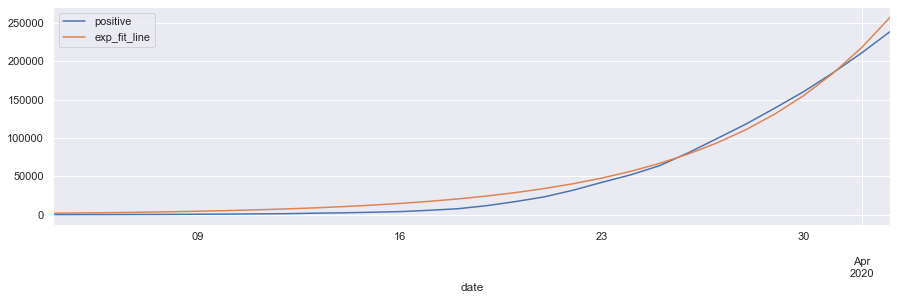

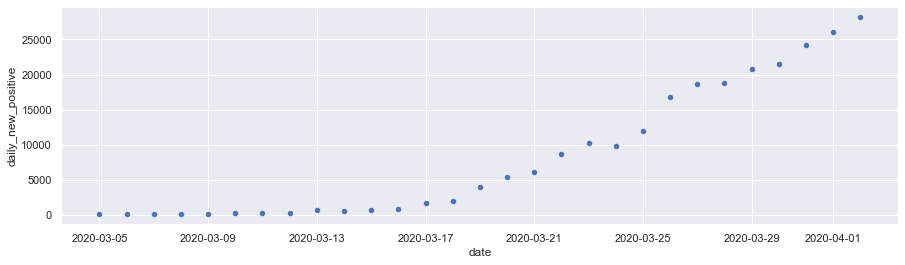

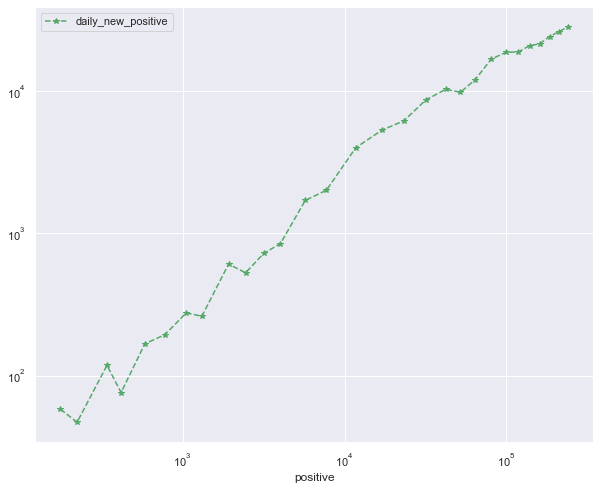

In [9]:
last_n_days = 10
dfa, dt, lud = get_state_doubling_df(df, "*", use_last_n_days=last_n_days)
lu = str(lud)[:16]
print("US Total Positive, doubling every {:.3} days\n  as of {}".format(dt, lu))
print("  based on last {} days of data".format(last_n_days))
dfa.plot(x="date", y=["positive", "exp_fit_line"], figsize=[15,4])
dfa.plot.scatter(x="date", y="daily_new_positive", figsize=[15,4])
dfa.plot(x="positive", y="daily_new_positive", figsize=[10,8], style="*--g", logy=True, logx=True)
plt.show()

### Testing

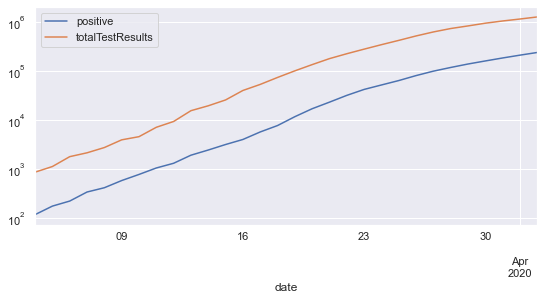

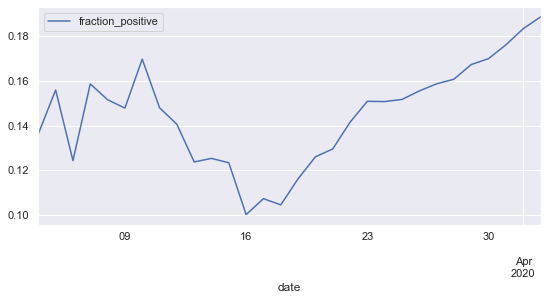

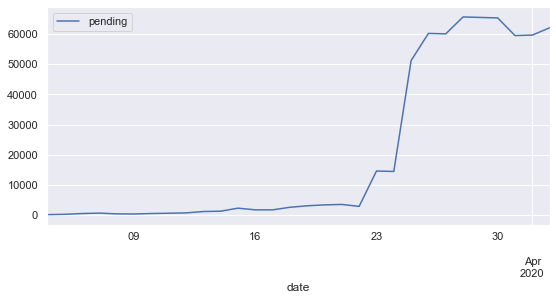

In [10]:
dfus["fraction_positive"] = dfus["positive"]/ dfus["totalTestResults"]
ax = dfus.plot(x="date", y="positive", logy=True, figsize=[9,4])
dfus.plot("date", "totalTestResults", logy=True, ax=ax)
dfus.plot("date", "fraction_positive", figsize=[9,4])
dfus.plot("date", "pending", figsize=[9,4])

### Current measured ratios and percentages

These are based on cases that test postive and test negative (state labs policies vary on this).

In [11]:
print("Current strategies for diagnosis give pos/neg tests ratio of {:.1%}".format(
    dfus.positive.values[-1]/(dfus.totalTestResults.values[-1])))
print("on total tests tracked = {:,}".format(int(dfus.totalTestResults.values[-1])))

Current strategies for diagnosis give pos/neg tests ratio of 18.9%
on total tests tracked = 1,267,658


In [12]:
pos_dr = dfus.death.values[-1]/dfus.positive.values[-1]
print("Current death/positive ratio of {:.1%}".format(pos_dr))

Current death/positive ratio of 2.4%


In [13]:
projections(dfus, dt, pos_dr)
projections(dfus, 2*dt, pos_dr)


US flu death rate average per week = 61,099/52 ≈ 1,174
Using doubling time of 4.11 days
period      date         positive,     deaths              weekly rate
-------------------------------------------------------------------------------------
   0: 2020-04-02 00 h,    239,009 [total deaths  5,784] Death Rate Avg = 1,446 per wk
   1: 2020-04-06 02 h,    478,018 [total deaths 11,568] Death Rate Avg = 2,521 per wk
   2: 2020-04-10 05 h,    956,036 [total deaths 23,136] Death Rate Avg = 4,471 per wk
   3: 2020-04-14 07 h,  1,912,072 [total deaths 46,272] Death Rate Avg = 8,031 per wk

US flu death rate average per week = 61,099/52 ≈ 1,174
Using doubling time of 8.22 days
period      date         positive,     deaths              weekly rate
-------------------------------------------------------------------------------------
   0: 2020-04-02 00 h,    239,009 [total deaths  5,784] Death Rate Avg = 1,446 per wk
   1: 2020-04-10 05 h,    478,018 [total deaths 11,568] Death Rate Avg = 2,235

### State Trends and Doubling Periods

State=NY  (last_update=2020-04-02T11:45)
Doubling every 4.89 days based on last 10 days of data
(naive estimates: current_unresolved=71506 hosp=10725 icu=2860)


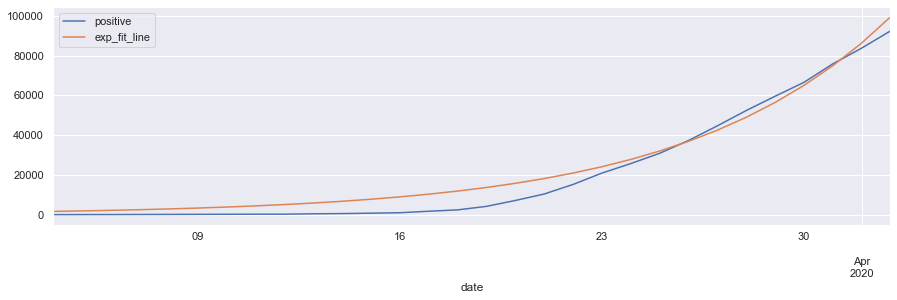

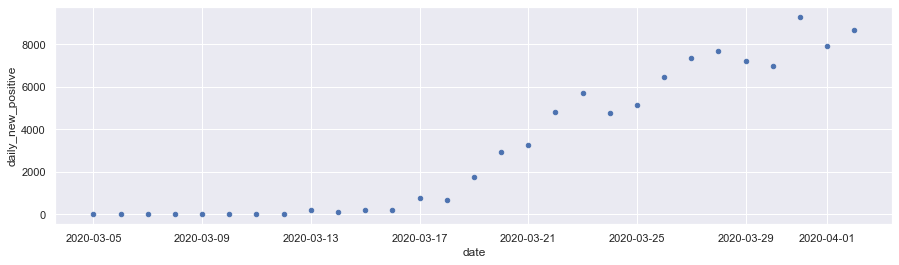

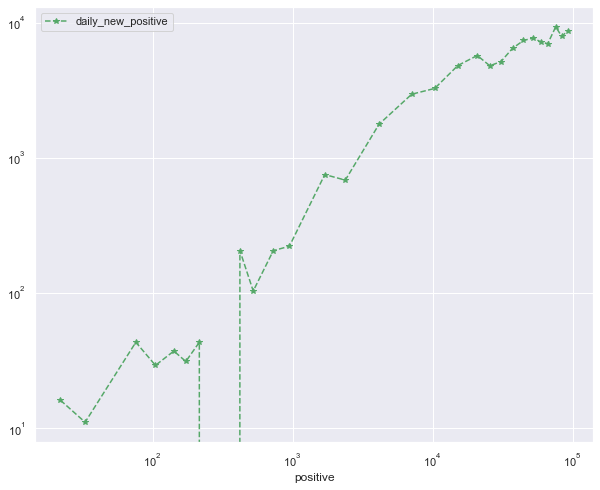

State=NJ  (last_update=2020-04-02T13:00)
Doubling every 3.19 days based on last 10 days of data
(naive estimates: current_unresolved=22746 hosp=3411 icu=909)


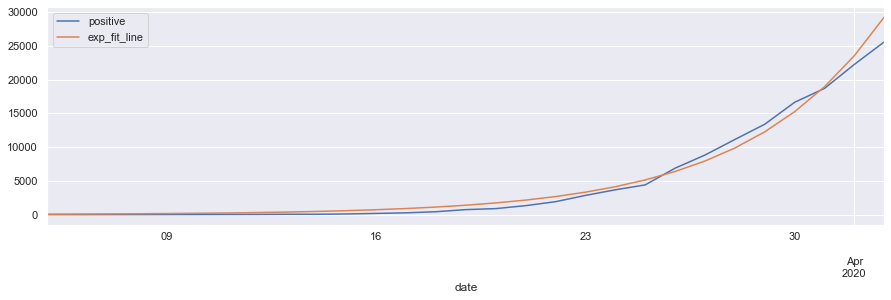

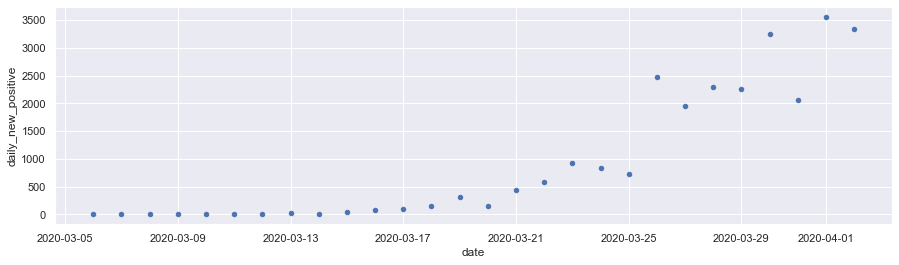

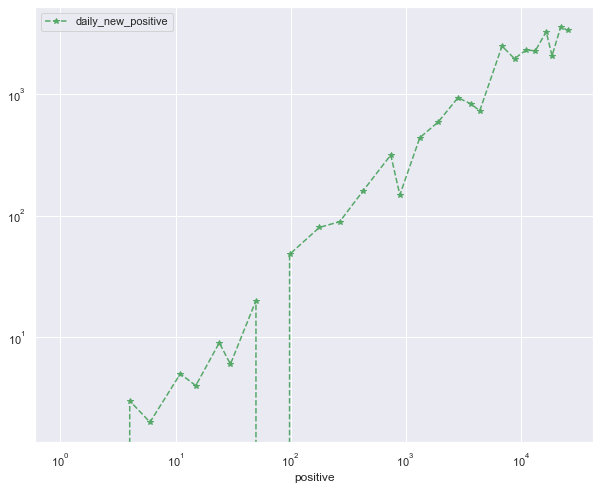

State=MI  (last_update=2020-04-02T11:00)
Doubling every 3.46 days based on last 10 days of data
(naive estimates: current_unresolved=9463 hosp=1419 icu=378)


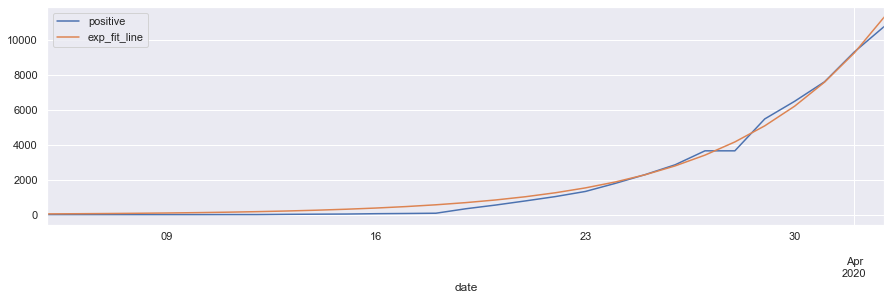

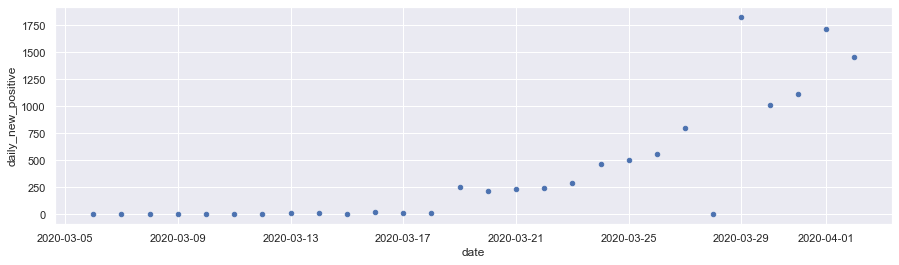

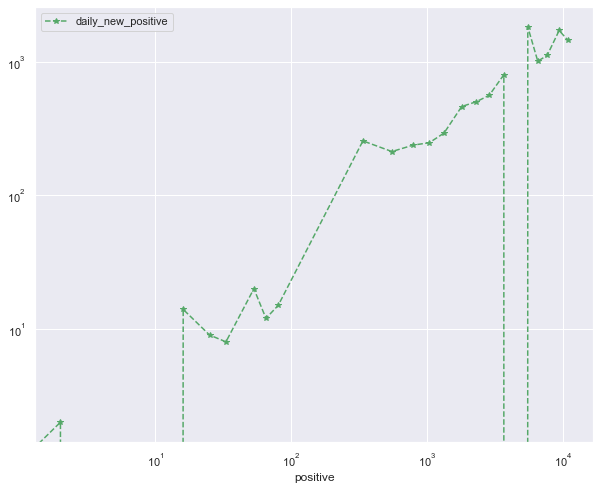

State=CA  (last_update=2020-04-02T00:00)
Doubling every 4.05 days based on last 10 days of data
(naive estimates: current_unresolved=7458 hosp=1118 icu=298)


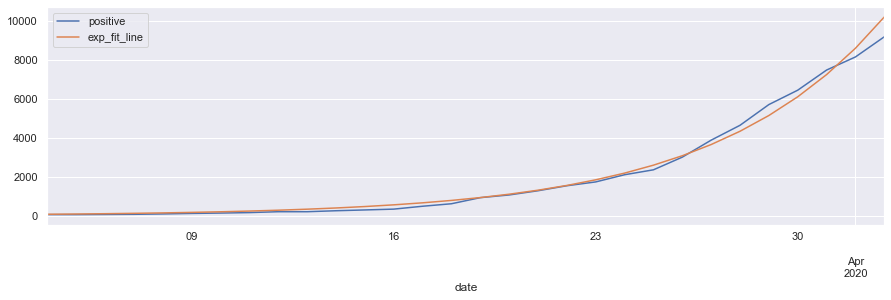

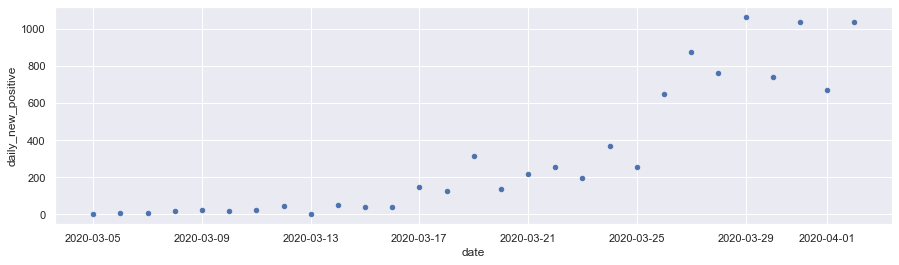

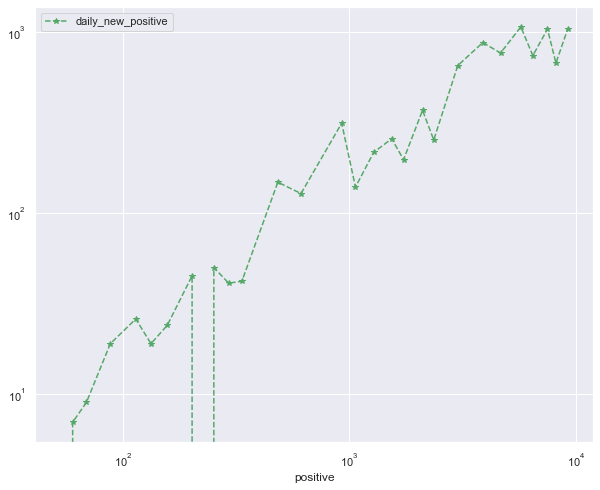

State=LA  (last_update=2020-04-02T13:00)
Doubling every 3.66 days based on last 10 days of data
(naive estimates: current_unresolved=7978 hosp=1196 icu=319)


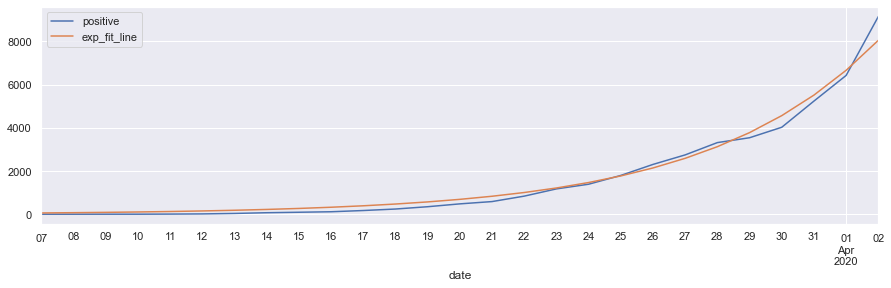

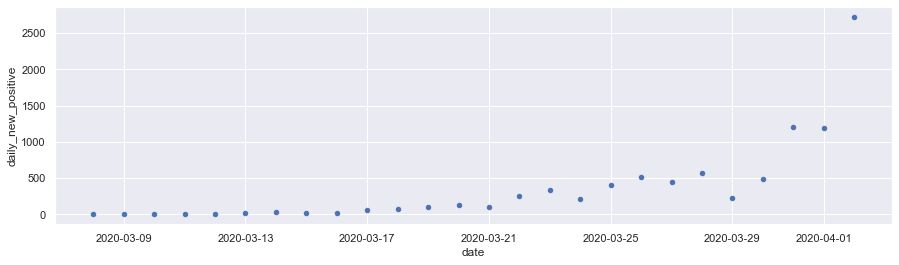

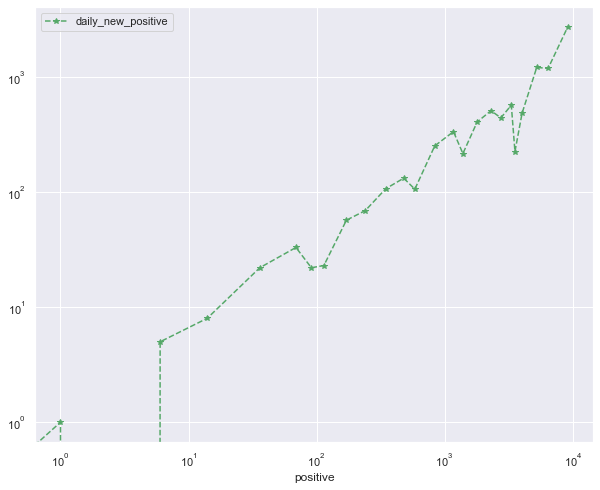

State=MA  (last_update=2020-04-02T16:00)
Doubling every 3.23 days based on last 10 days of data
(naive estimates: current_unresolved=8189 hosp=1228 icu=327)


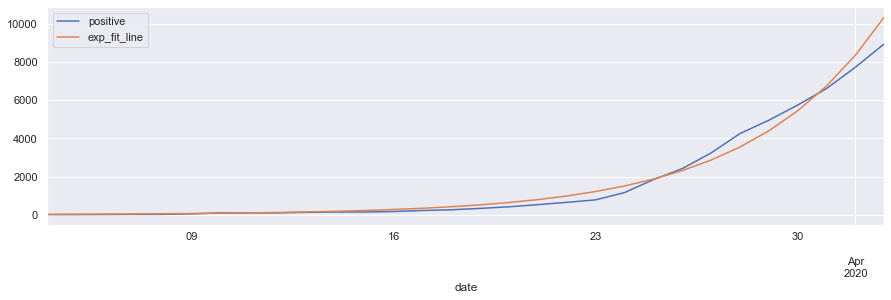

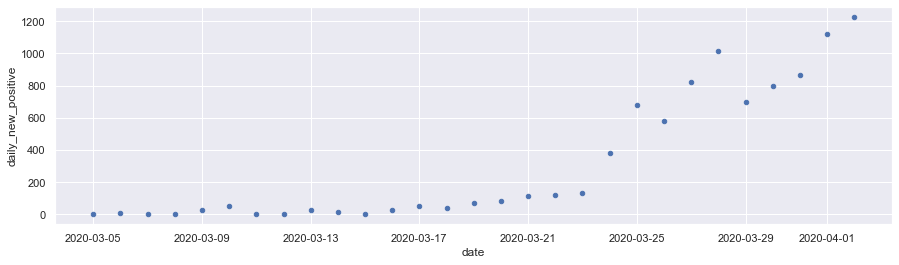

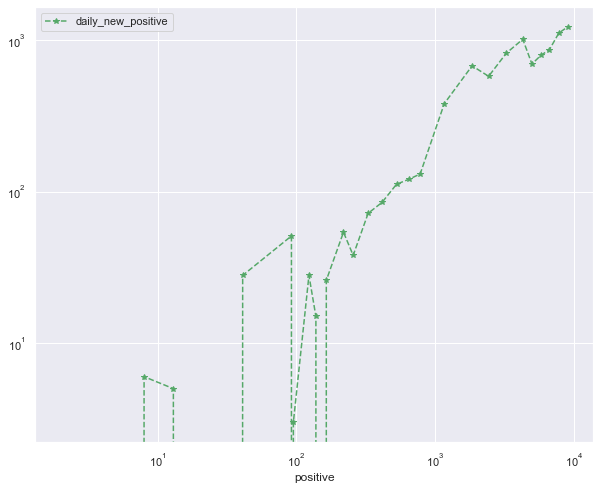

State=FL  (last_update=2020-04-02T11:01)
Doubling every 3.5 days based on last 10 days of data
(naive estimates: current_unresolved=6839 hosp=1025 icu=273)


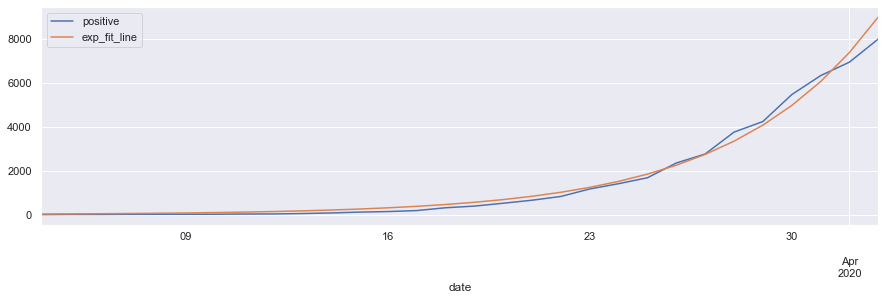

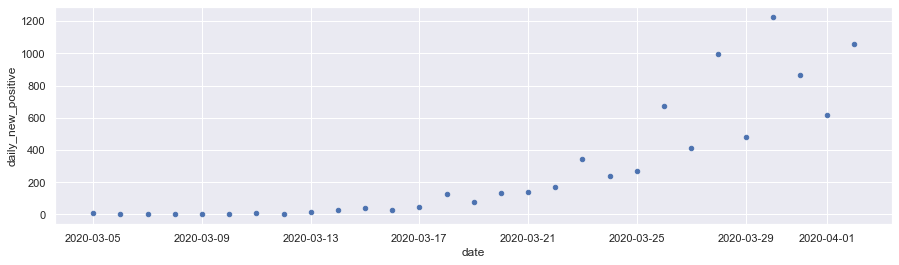

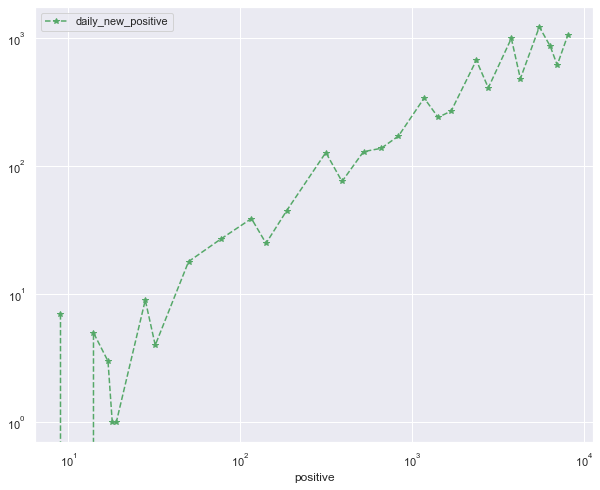

State=IL  (last_update=2020-04-02T00:00)
Doubling every 3.83 days based on last 10 days of data
(naive estimates: current_unresolved=6422 hosp=963 icu=256)


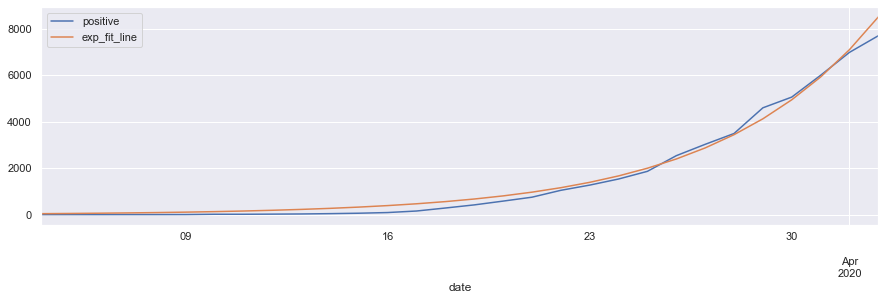

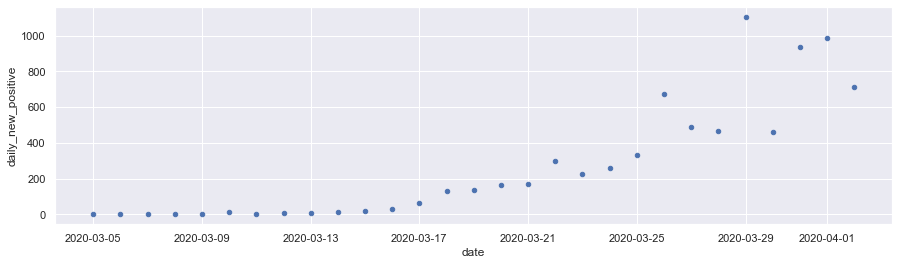

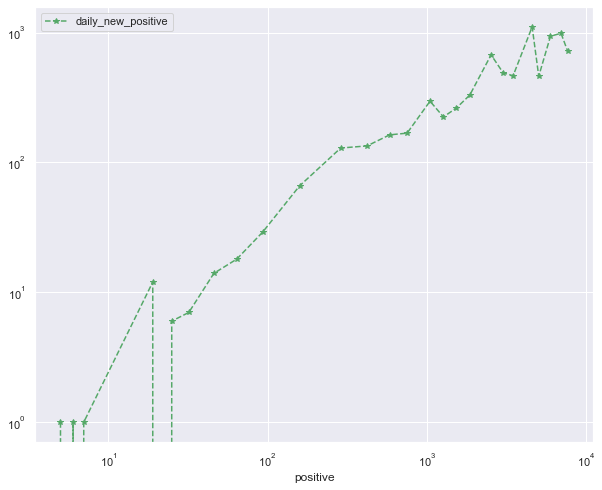

State=PA  (last_update=2020-04-02T12:00)
Doubling every 3.03 days based on last 10 days of data
(naive estimates: current_unresolved=6372 hosp=955 icu=254)


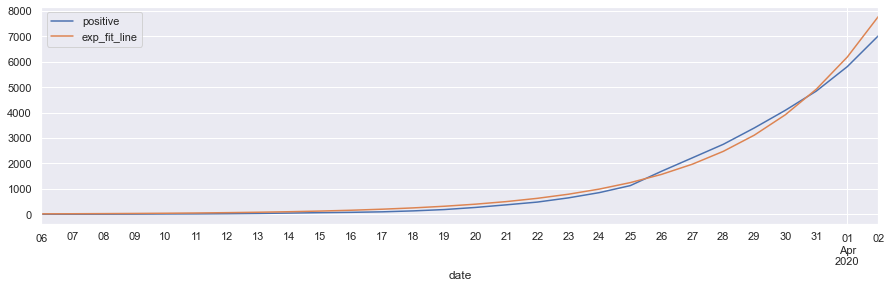

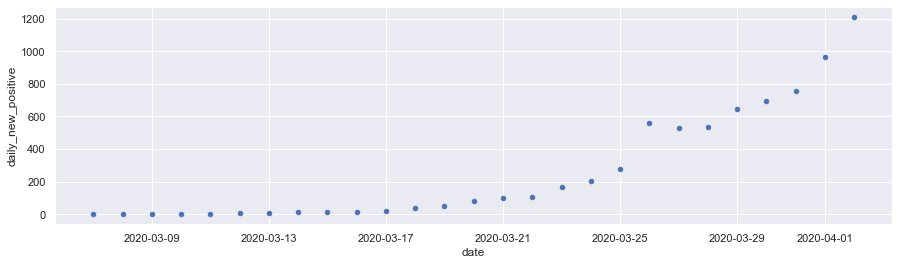

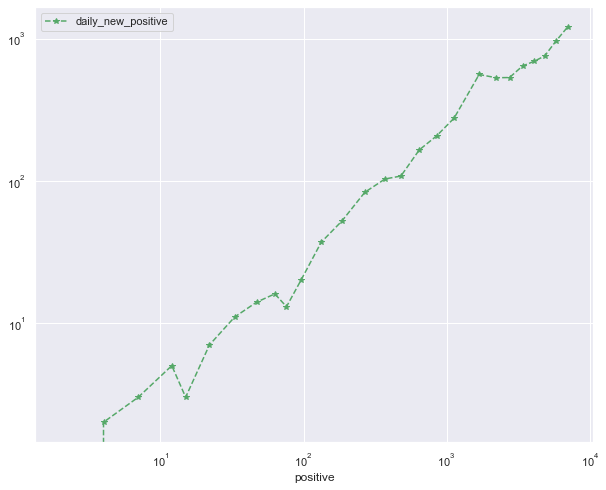

State=WA  (last_update=2020-04-01T20:00)
Doubling every 5.92 days based on last 10 days of data
(naive estimates: current_unresolved=3988 hosp=598 icu=159)


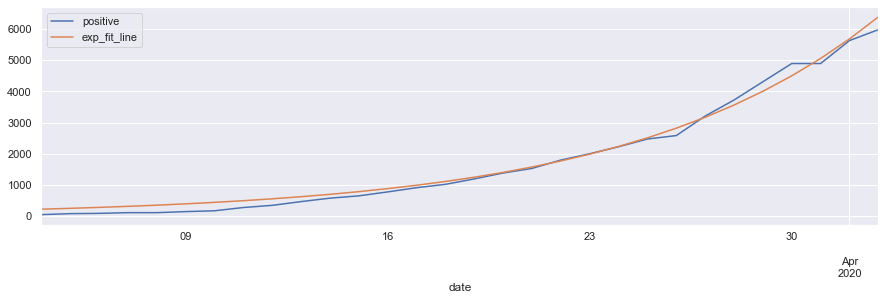

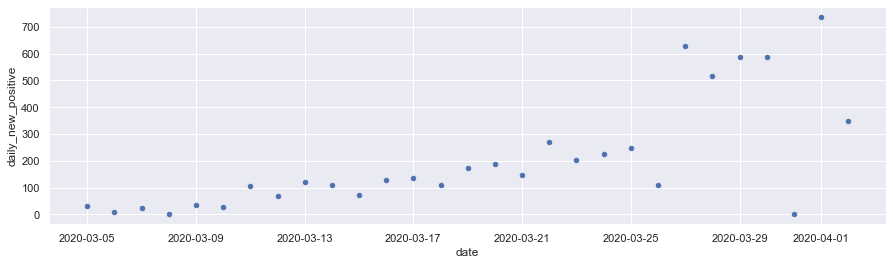

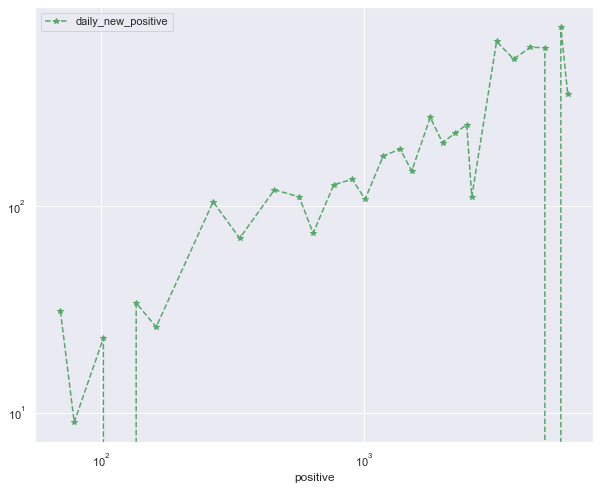

State=GA  (last_update=2020-04-02T11:28)
Doubling every 3.82 days based on last 10 days of data
(naive estimates: current_unresolved=4576 hosp=686 icu=183)


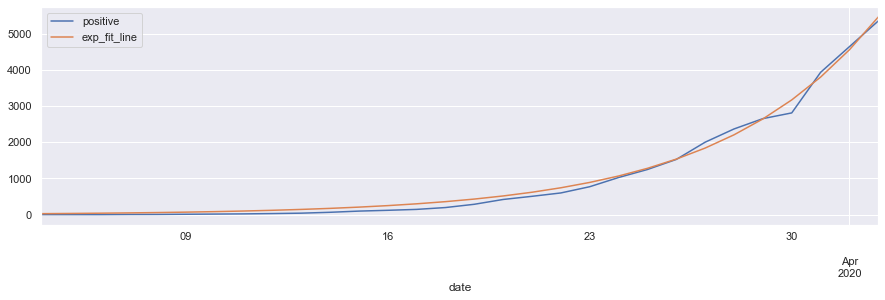

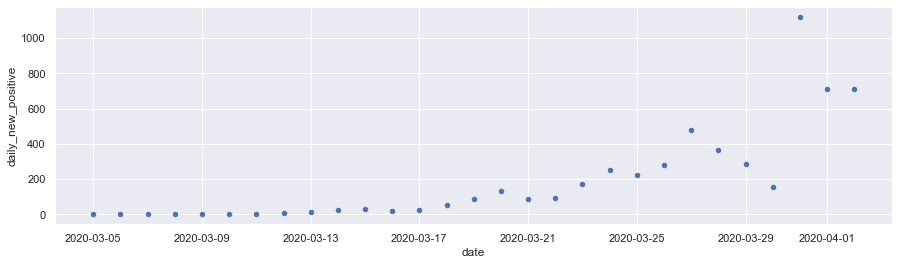

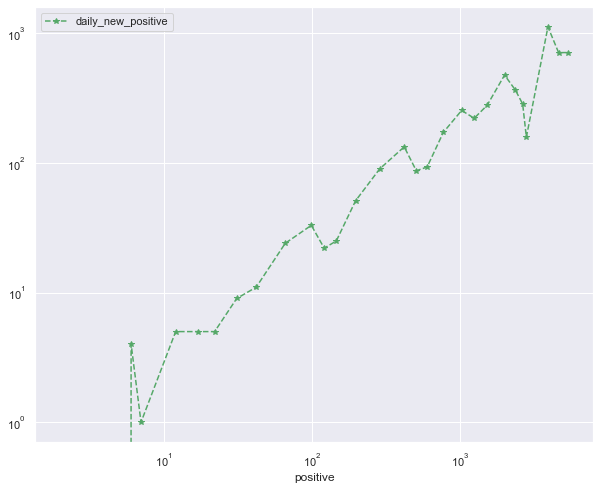

State=TX  (last_update=2020-04-01T21:00)
Doubling every 3.03 days based on last 10 days of data
(naive estimates: current_unresolved=4317 hosp=647 icu=172)


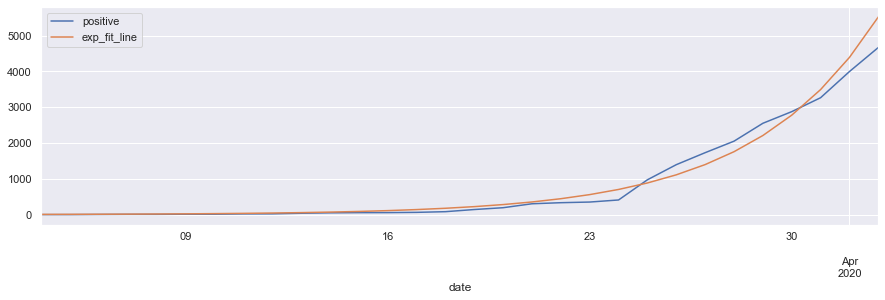

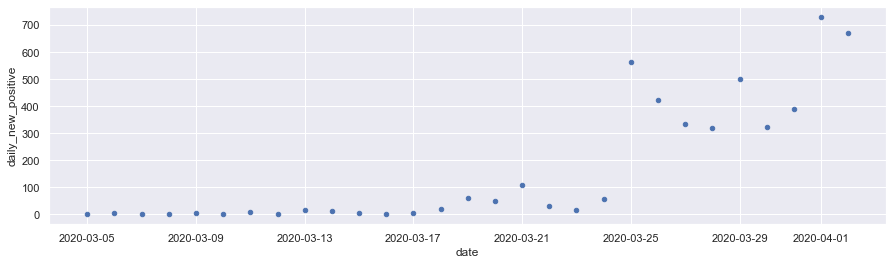

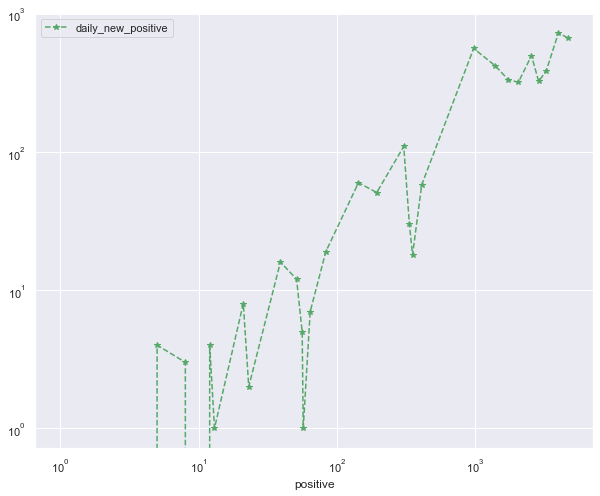

State=CT  (last_update=2020-04-02T15:30)
Doubling every 3.33 days based on last 10 days of data
(naive estimates: current_unresolved=3409 hosp=511 icu=136)


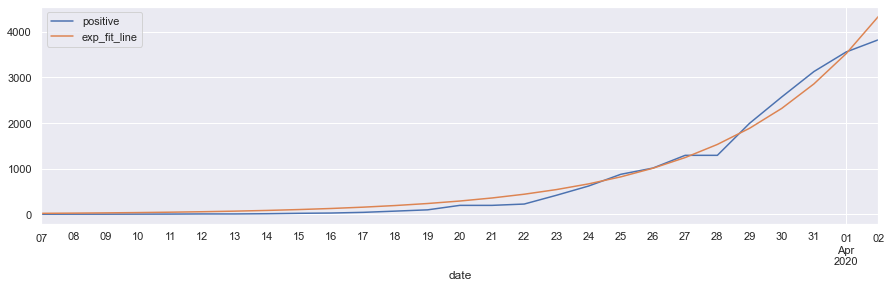

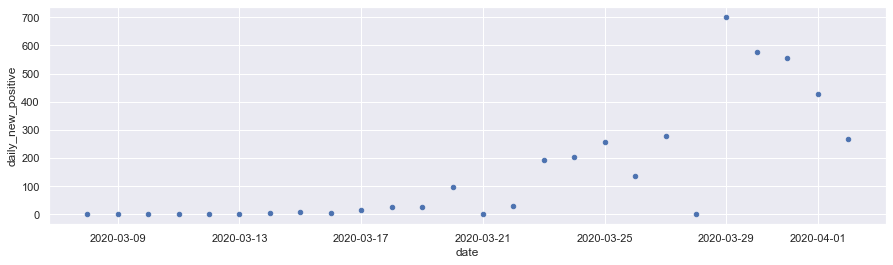

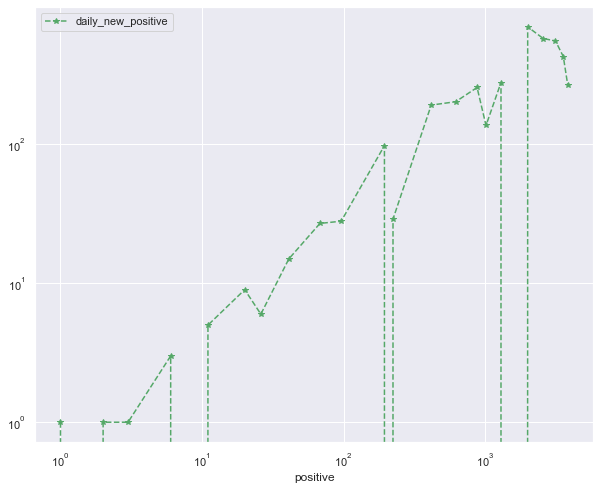

State=CO  (last_update=2020-04-01T18:00)
Doubling every 4.02 days based on last 10 days of data
(naive estimates: current_unresolved=2751 hosp=412 icu=110)


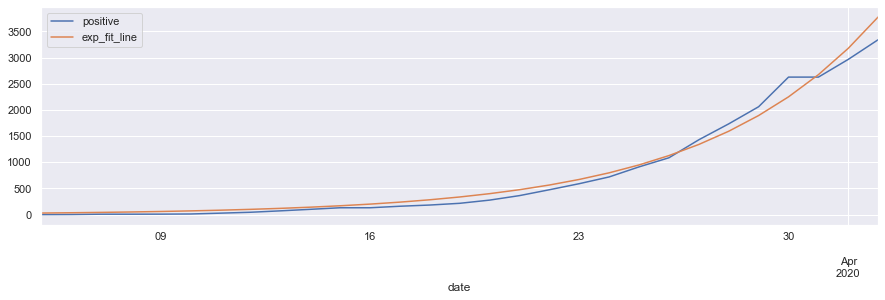

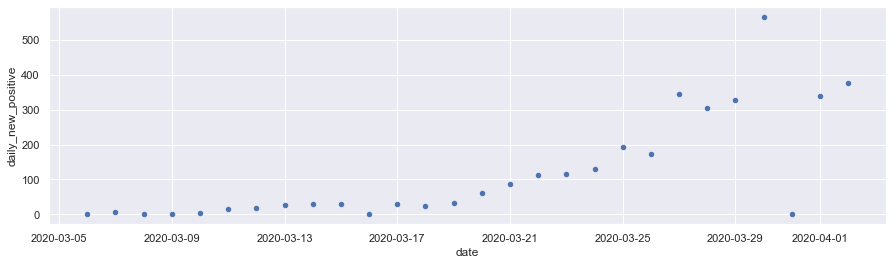

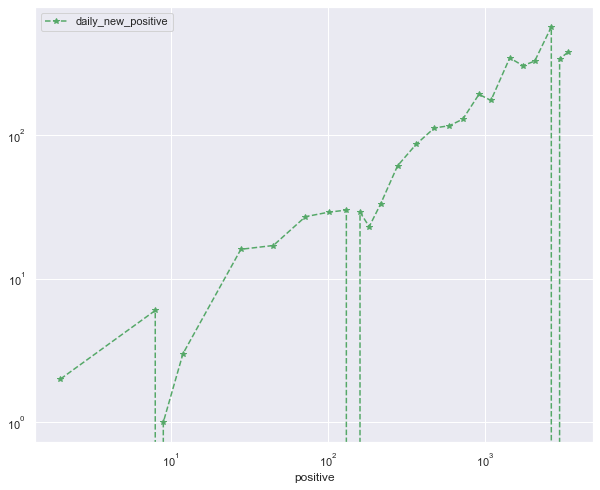

State=IN  (last_update=2020-04-01T23:59)
Doubling every 2.94 days based on last 10 days of data
(naive estimates: current_unresolved=2780 hosp=417 icu=111)


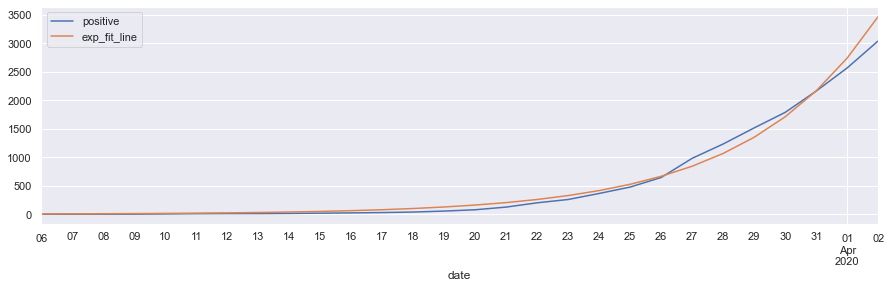

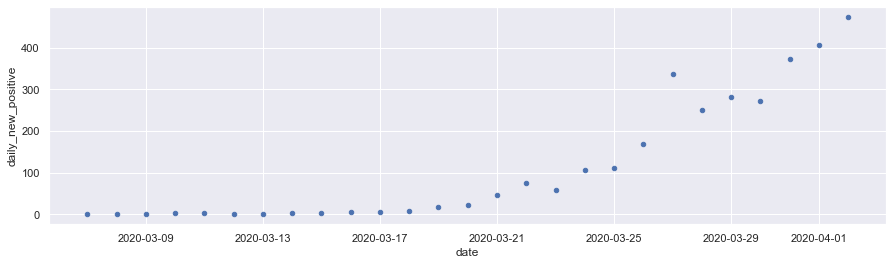

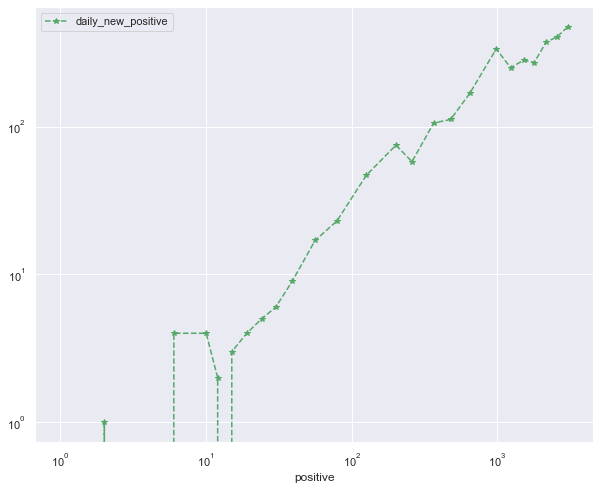

State=OH  (last_update=2020-04-02T14:00)
Doubling every 3.79 days based on last 10 days of data
(naive estimates: current_unresolved=2460 hosp=369 icu=98)


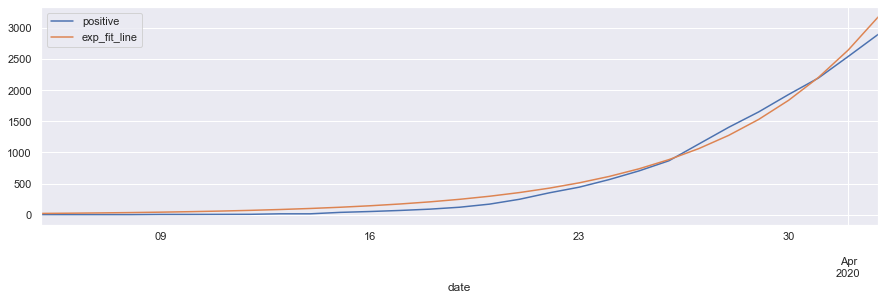

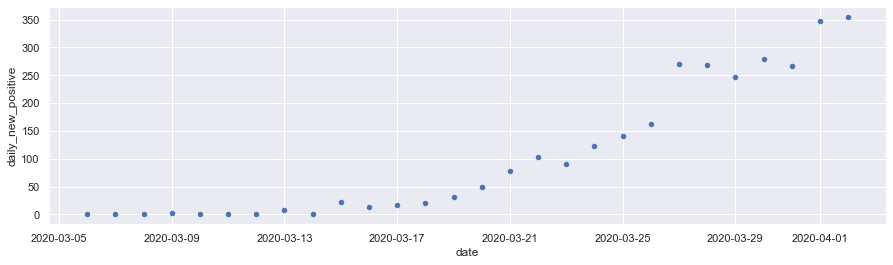

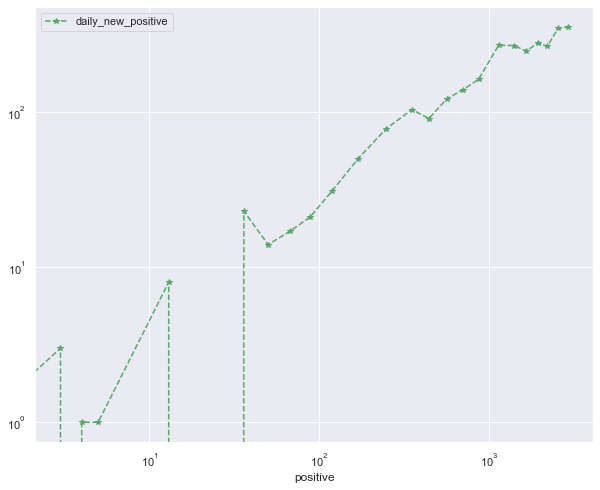

State=TN  (last_update=2020-04-02T15:00)
Doubling every 4.19 days based on last 10 days of data
(naive estimates: current_unresolved=2230 hosp=334 icu=89)


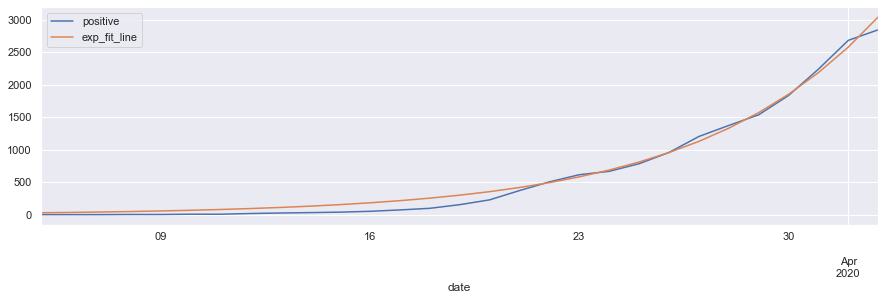

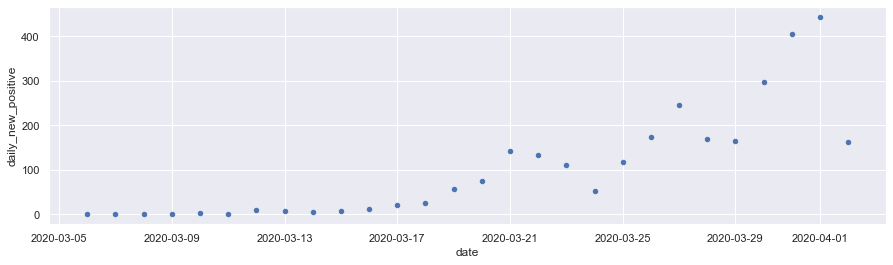

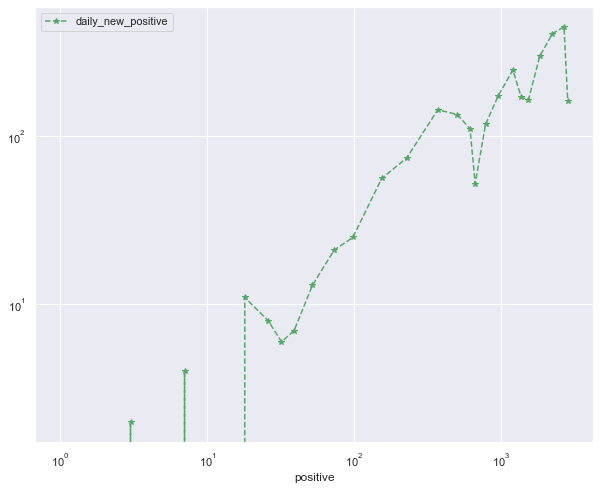

State=MD  (last_update=2020-04-02T10:00)
Doubling every 3.25 days based on last 10 days of data
(naive estimates: current_unresolved=2043 hosp=306 icu=81)


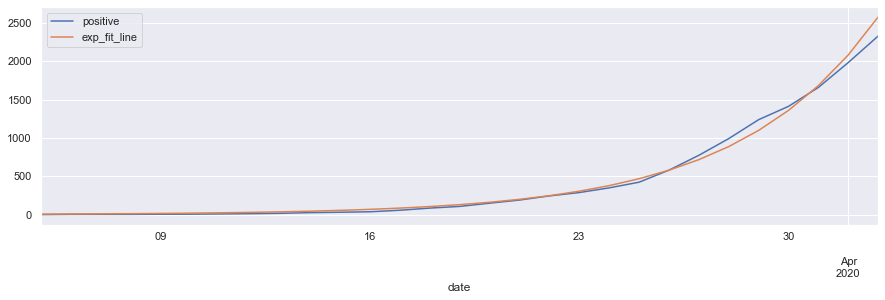

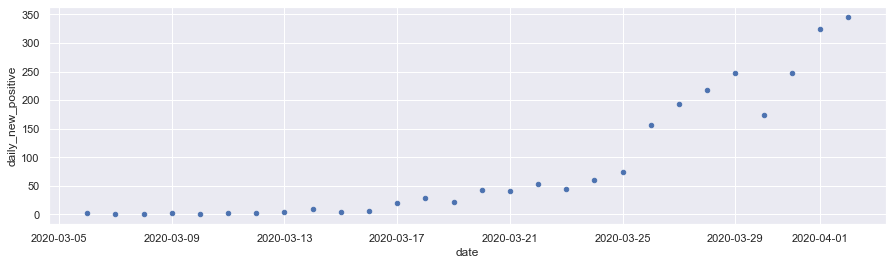

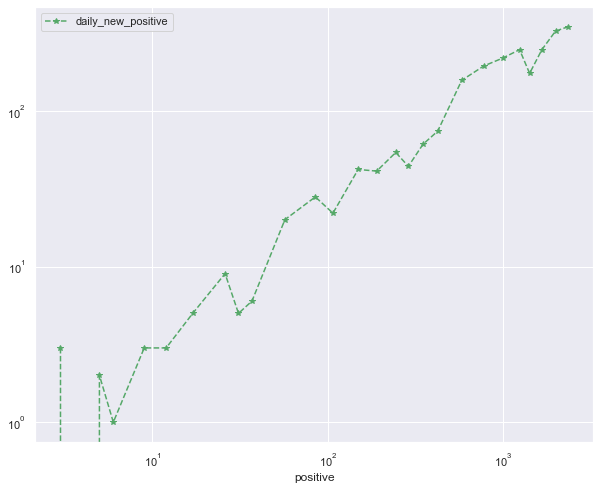

State=NC  (last_update=2020-04-02T14:00)
Doubling every 4.1 days based on last 10 days of data
(naive estimates: current_unresolved=1560 hosp=234 icu=62)


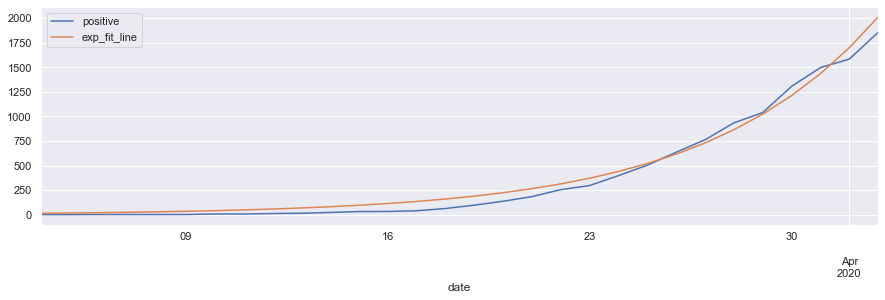

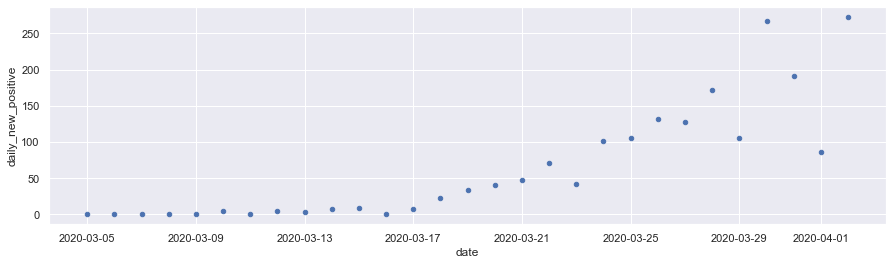

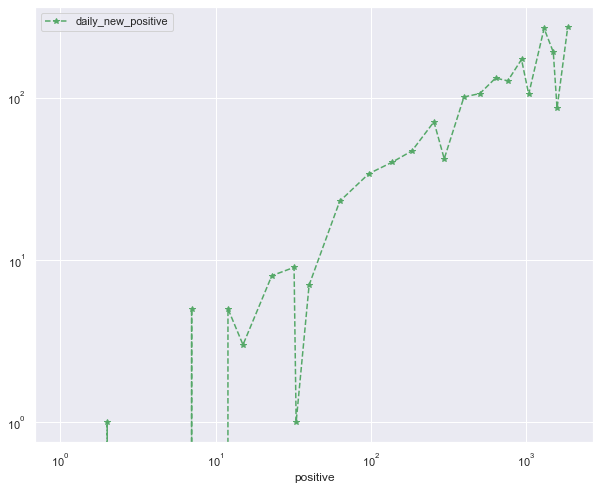

State=MO  (last_update=2020-04-02T15:00)
Doubling every 3.06 days based on last 10 days of data
(naive estimates: current_unresolved=1651 hosp=247 icu=66)


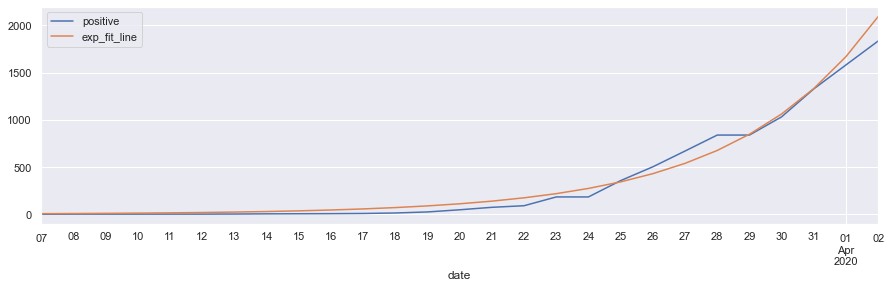

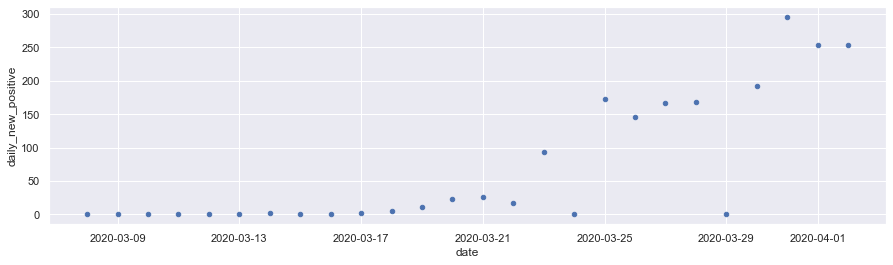

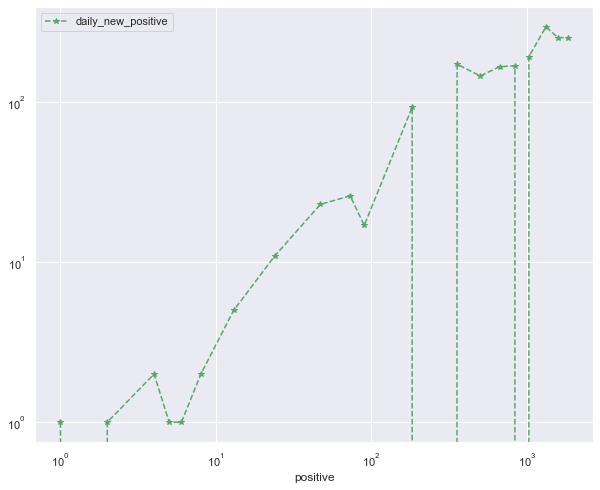

State=WI  (last_update=2020-04-02T16:00)
Doubling every 4.91 days based on last 10 days of data
(naive estimates: current_unresolved=1314 hosp=197 icu=52)


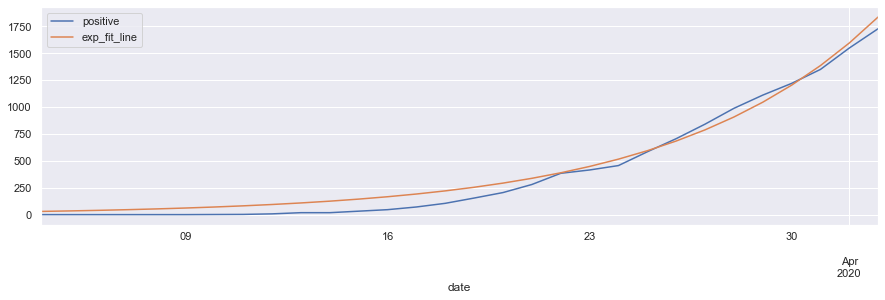

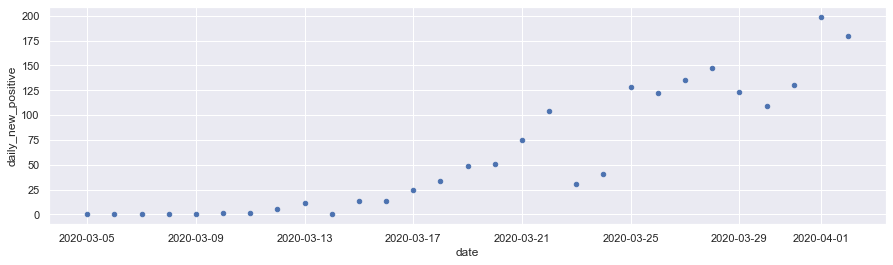

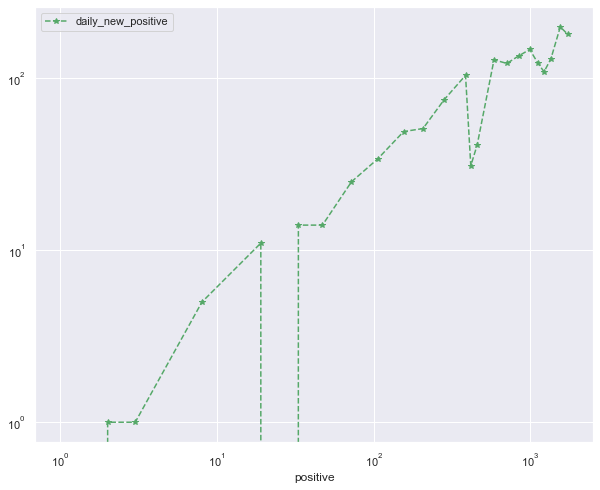

State=VA  (last_update=2020-04-02T09:00)
Doubling every 3.57 days based on last 10 days of data
(naive estimates: current_unresolved=1452 hosp=217 icu=58)


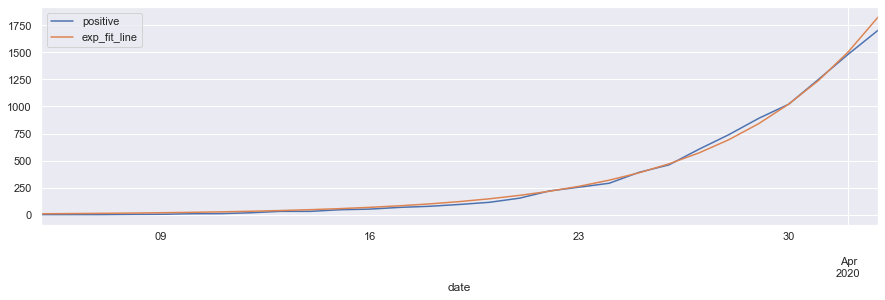

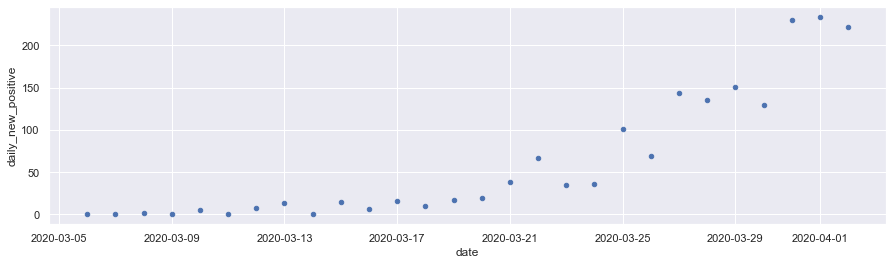

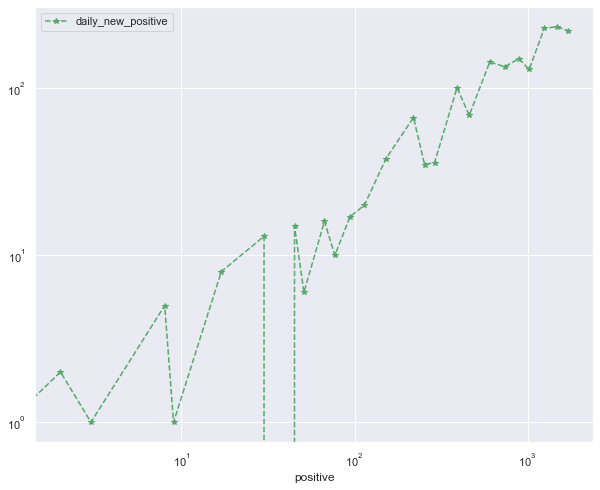

State=AZ  (last_update=2020-04-02T00:00)
Doubling every 4.25 days based on last 10 days of data
(naive estimates: current_unresolved=1333 hosp=199 icu=53)


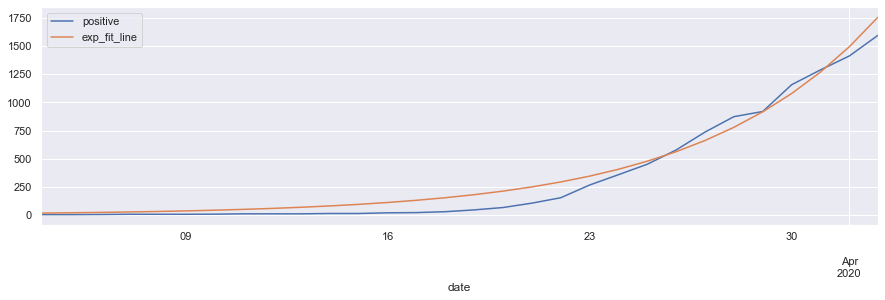

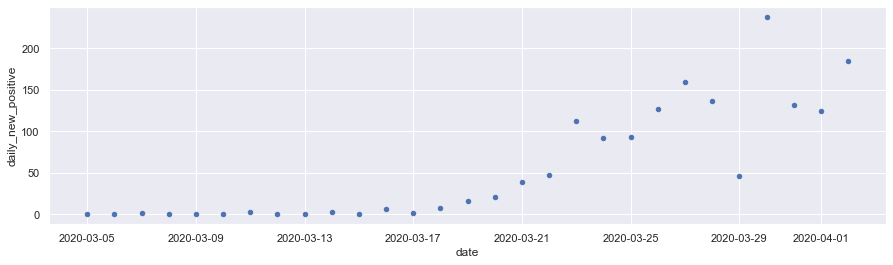

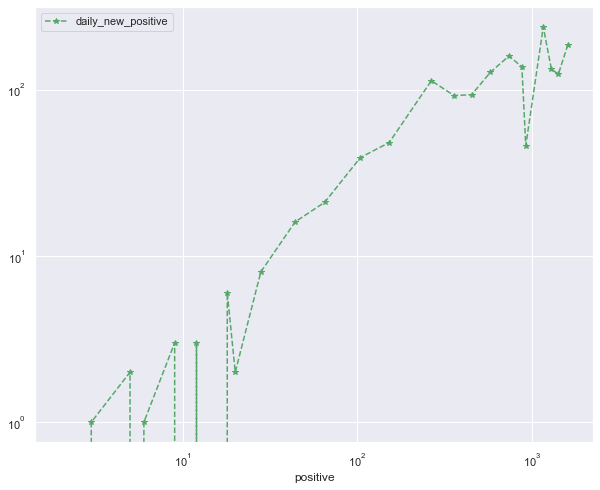

State=SC  (last_update=2020-04-02T16:04)
Doubling every 3.88 days based on last 10 days of data
(naive estimates: current_unresolved=1255 hosp=188 icu=50)


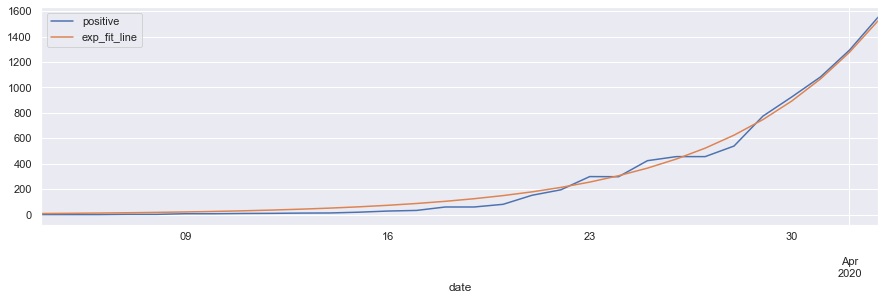

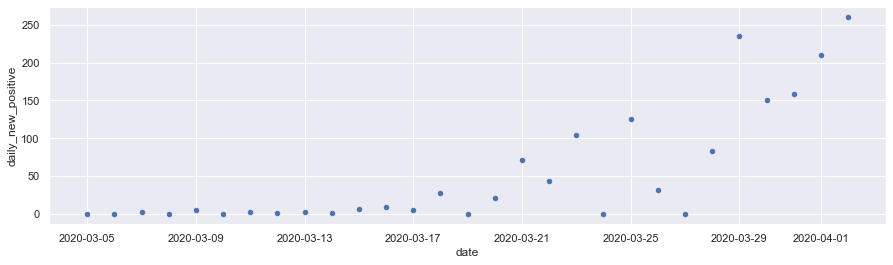

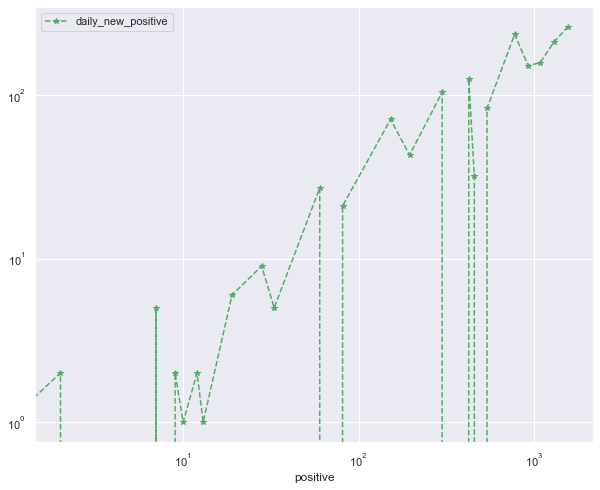

State=NV  (last_update=2020-04-02T09:30)
Doubling every 3.63 days based on last 10 days of data
(naive estimates: current_unresolved=1213 hosp=181 icu=48)


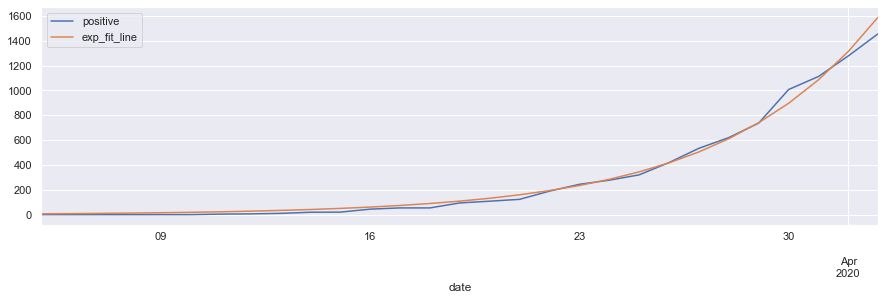

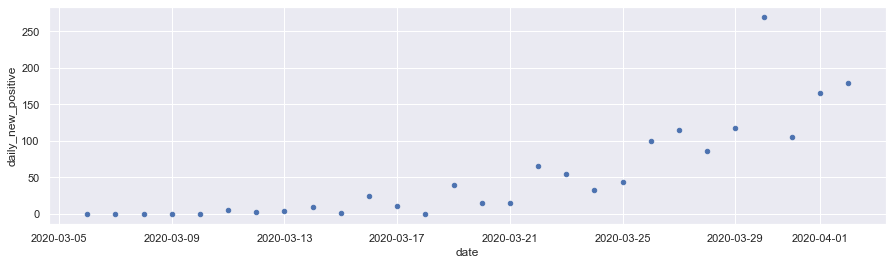

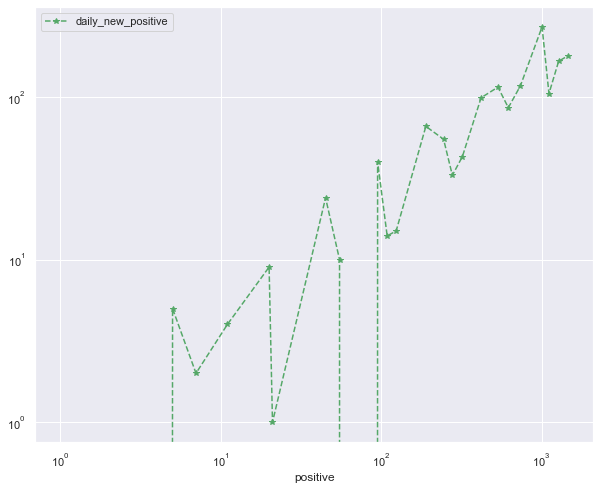

State=AL  (last_update=2020-04-02T00:00)
Doubling every 3.85 days based on last 10 days of data
(naive estimates: current_unresolved=1066 hosp=159 icu=42)


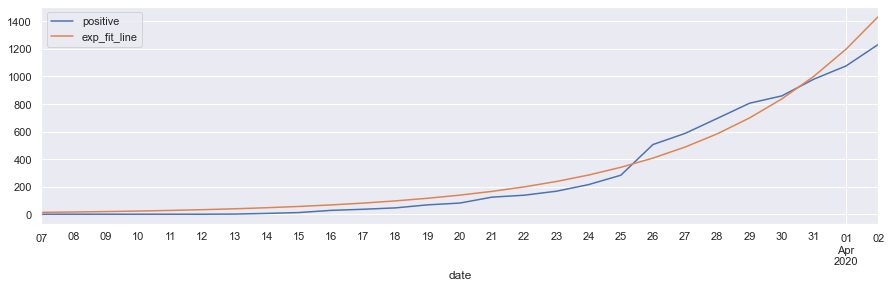

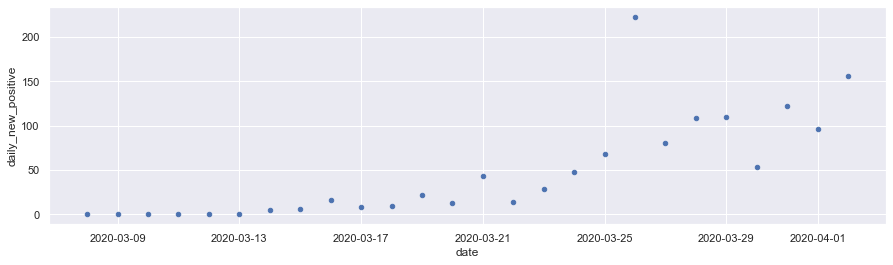

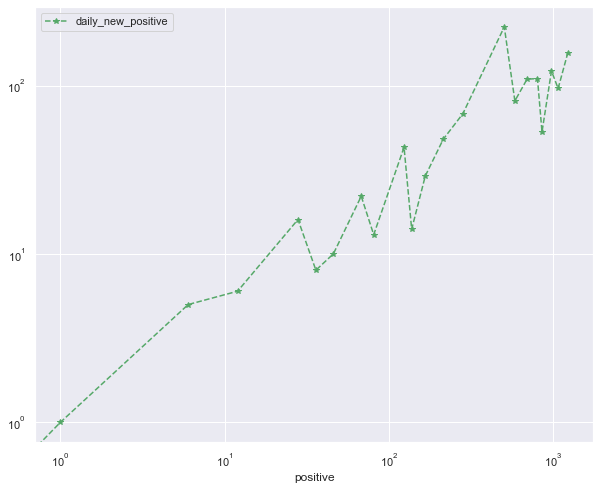

State=MS  (last_update=2020-04-01T19:00)
Doubling every 4.84 days based on last 10 days of data
(naive estimates: current_unresolved=928 hosp=139 icu=37)


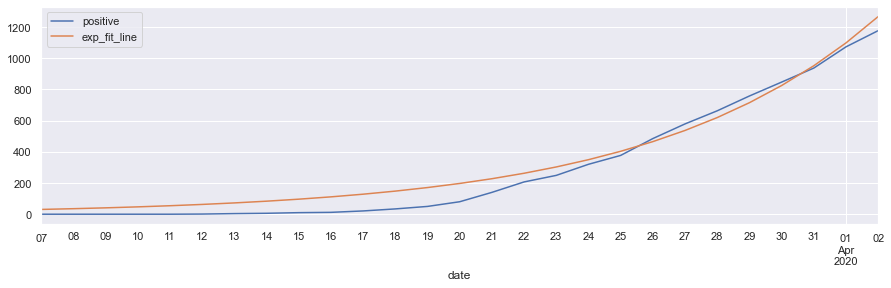

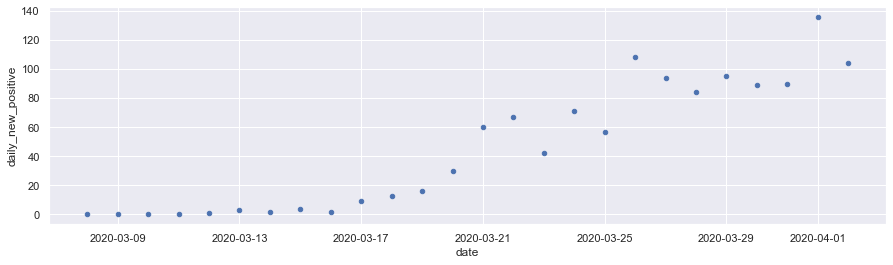

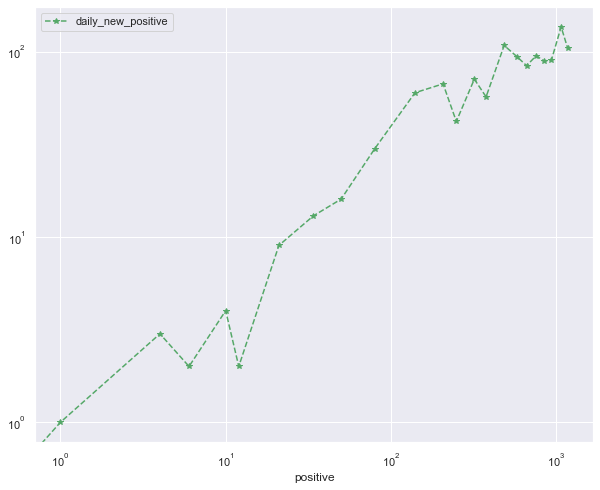

State=UT  (last_update=2020-04-02T15:00)
Doubling every 4.63 days based on last 10 days of data
(naive estimates: current_unresolved=817 hosp=122 icu=32)


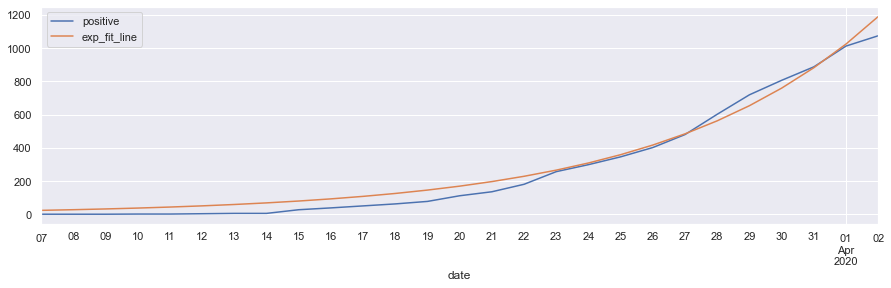

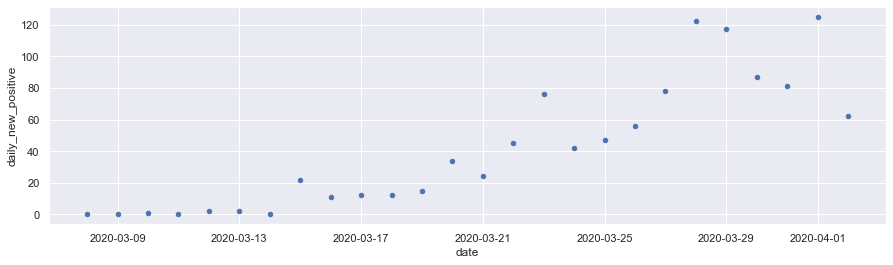

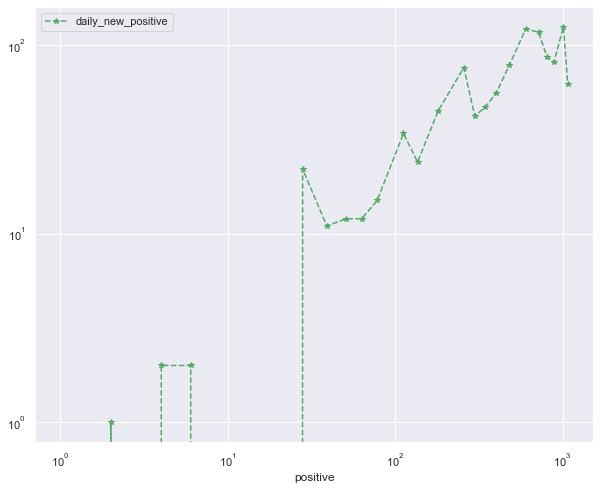

State=OK  (last_update=2020-04-01T08:00)
Doubling every 3.28 days based on last 10 days of data
(naive estimates: current_unresolved=798 hosp=119 icu=31)


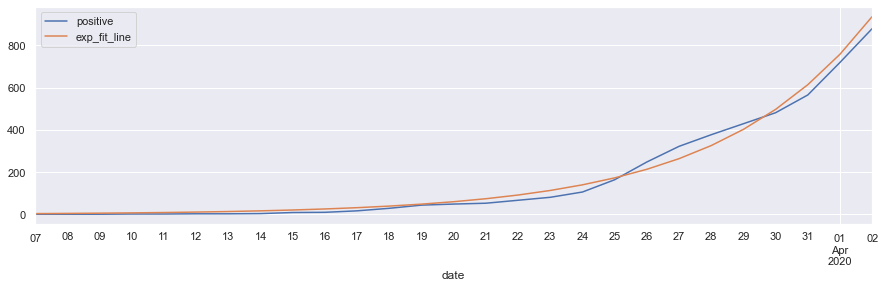

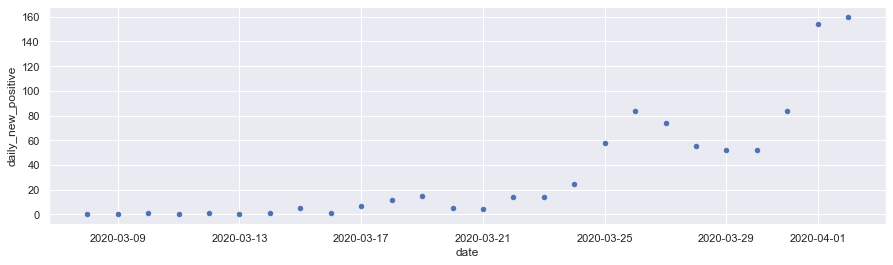

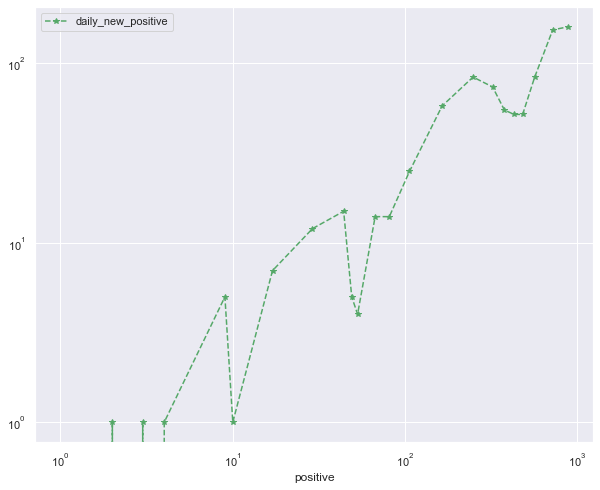

State=MN  (last_update=2020-04-02T12:00)
Doubling every 5.8 days based on last 10 days of data
(naive estimates: current_unresolved=507 hosp=76 icu=20)


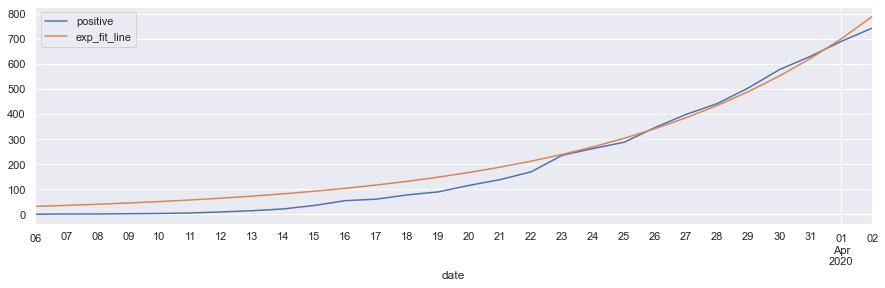

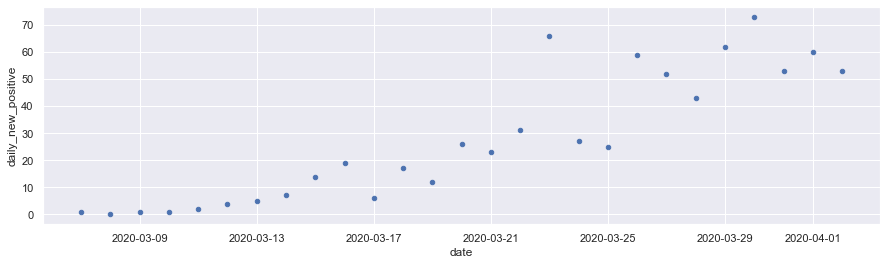

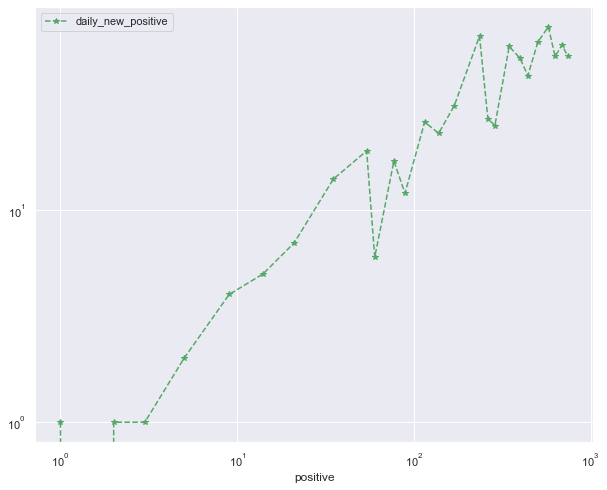

State=OR  (last_update=2020-04-01T11:00)
Doubling every 4.63 days based on last 10 days of data
(naive estimates: current_unresolved=545 hosp=81 icu=21)


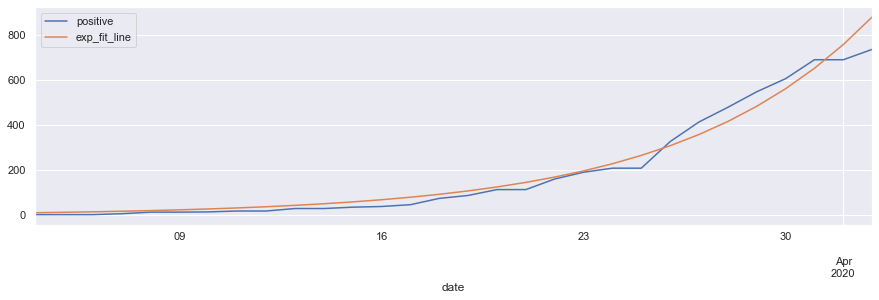

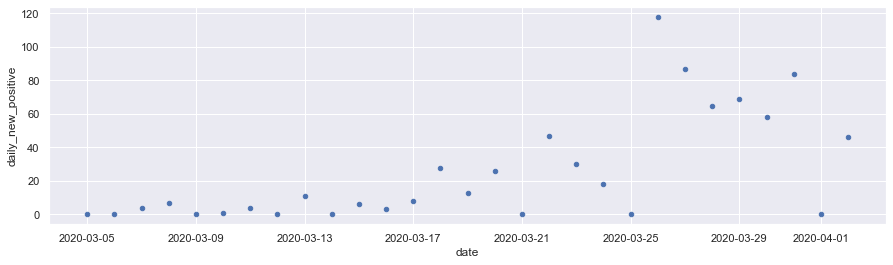

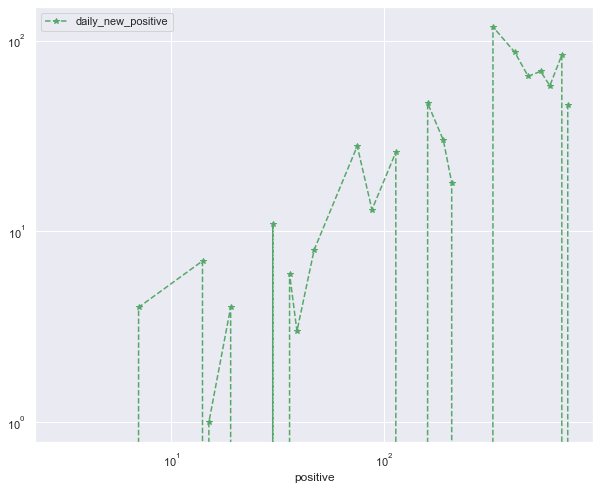

State=KY  (last_update=2020-04-01T17:00)
Doubling every 3.69 days based on last 10 days of data
(naive estimates: current_unresolved=576 hosp=86 icu=23)


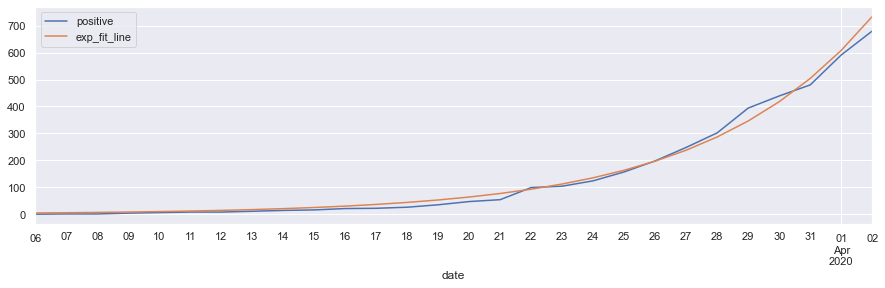

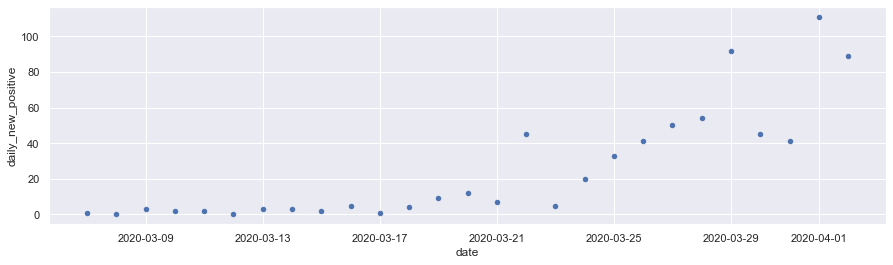

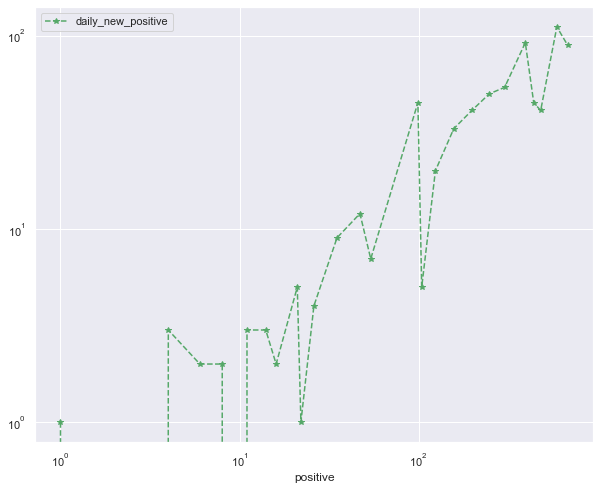

State=ID  (last_update=2020-04-01T19:00)
Doubling every 2.55 days based on last 10 days of data
(naive estimates: current_unresolved=622 hosp=93 icu=24)


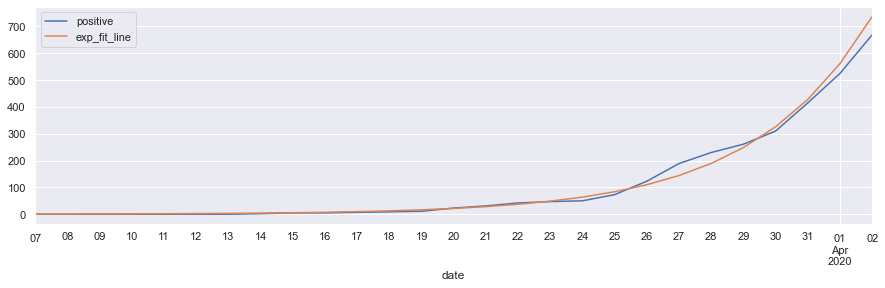

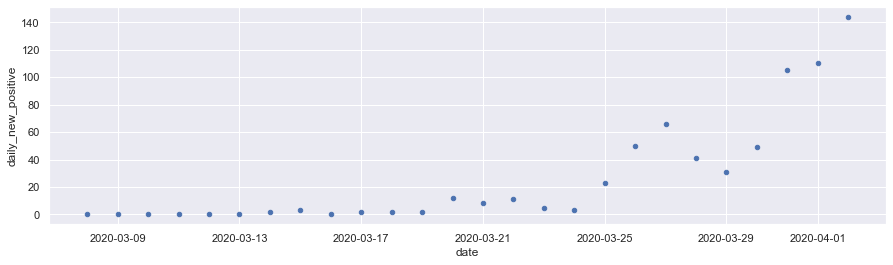

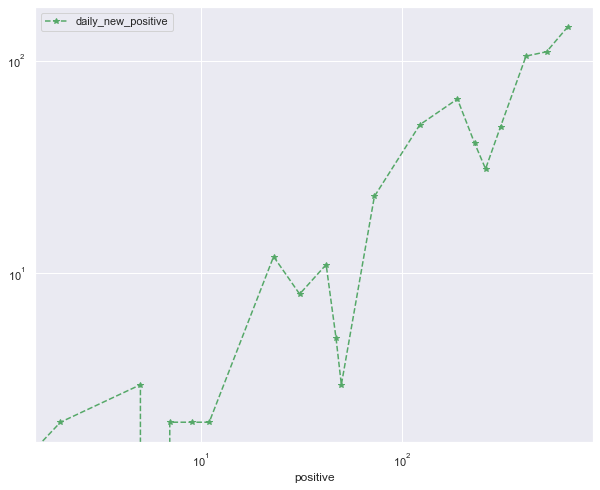

State=RI  (last_update=2020-04-02T15:58)
Doubling every 3.22 days based on last 10 days of data
(naive estimates: current_unresolved=551 hosp=82 icu=22)


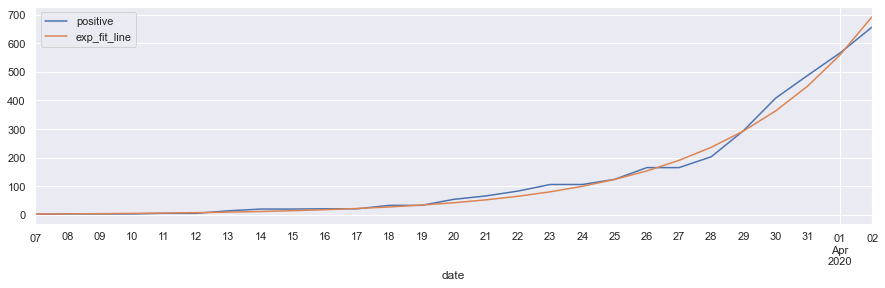

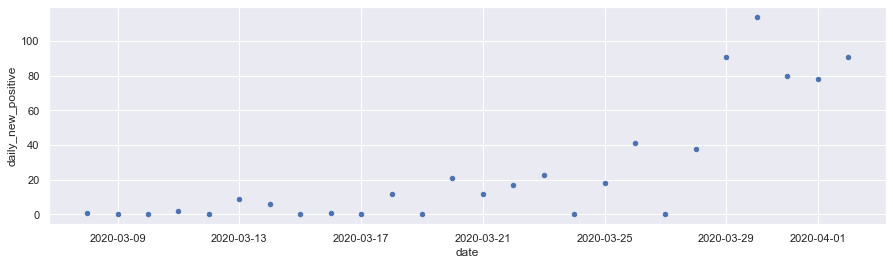

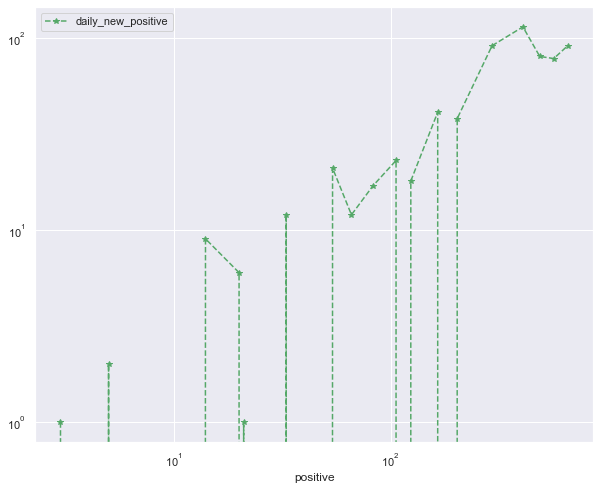

State=DC  (last_update=2020-04-02T09:00)
Doubling every 4.18 days based on last 10 days of data
(naive estimates: current_unresolved=537 hosp=80 icu=21)


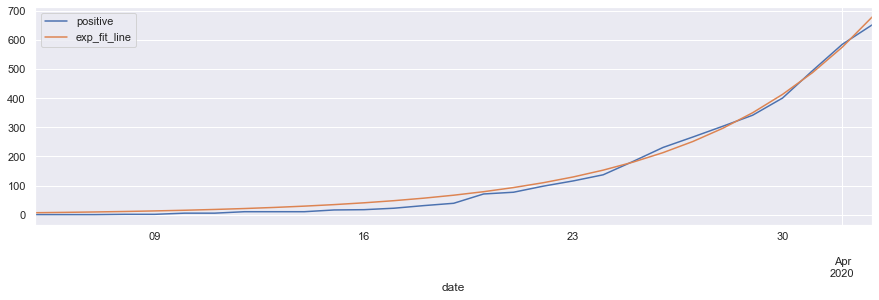

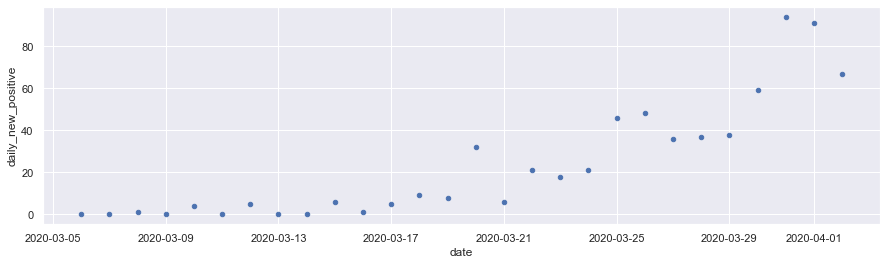

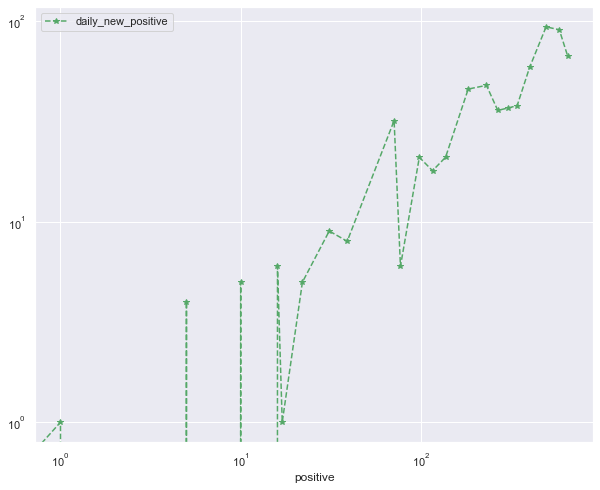

State=AR  (last_update=2020-04-02T14:45)
Doubling every 6.42 days based on last 10 days of data
(naive estimates: current_unresolved=469 hosp=70 icu=18)


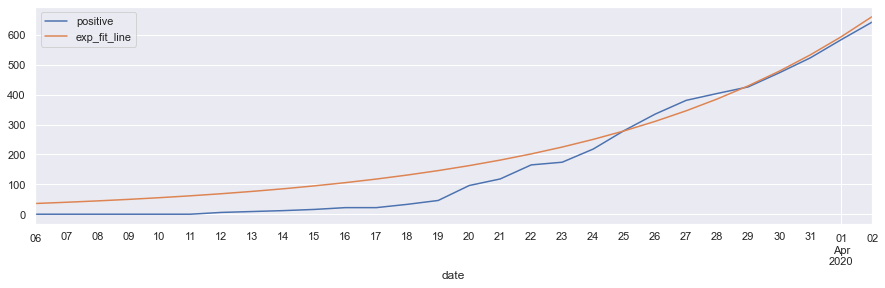

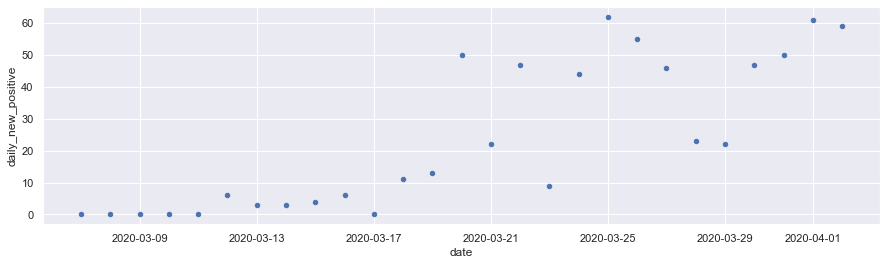

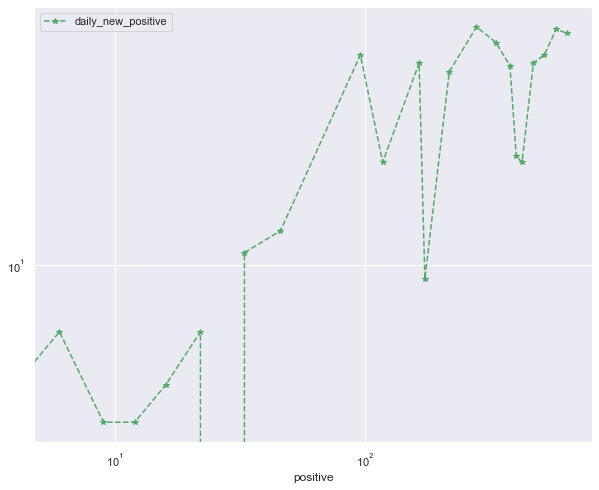

State=IA  (last_update=2020-04-02T00:00)
Doubling every 3.72 days based on last 10 days of data
(naive estimates: current_unresolved=509 hosp=76 icu=20)


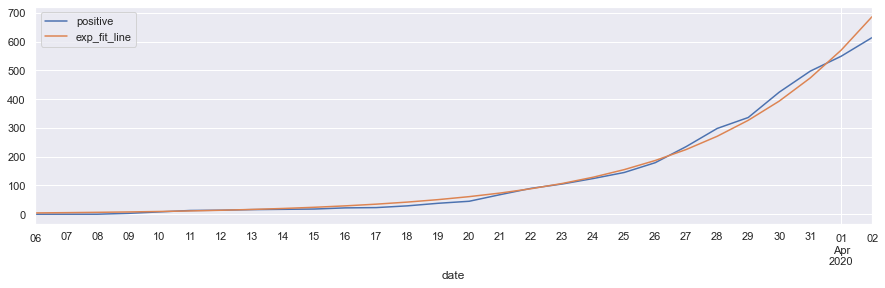

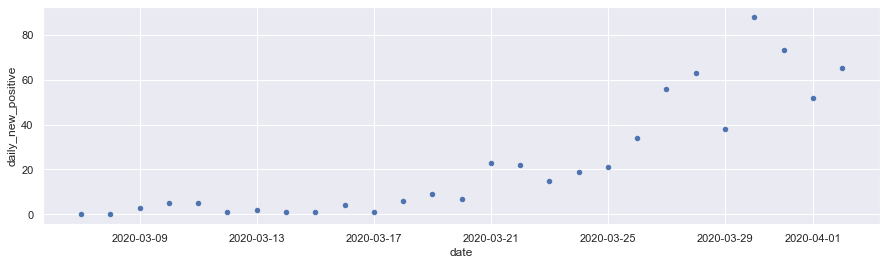

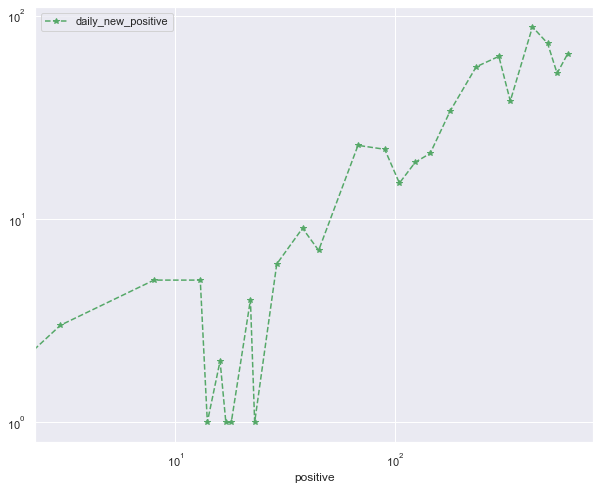

State=KS  (last_update=2020-04-02T12:00)
Doubling every 3.62 days based on last 10 days of data
(naive estimates: current_unresolved=470 hosp=70 icu=18)


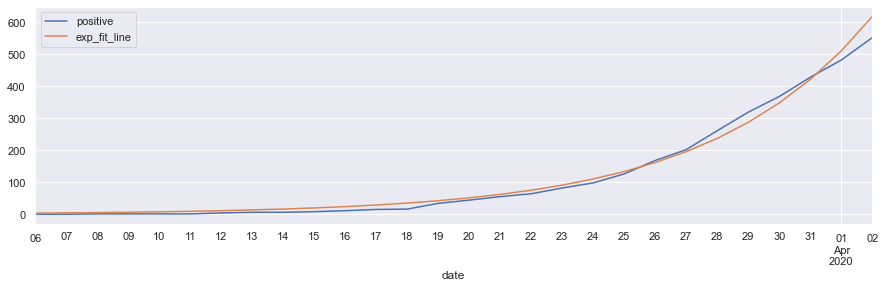

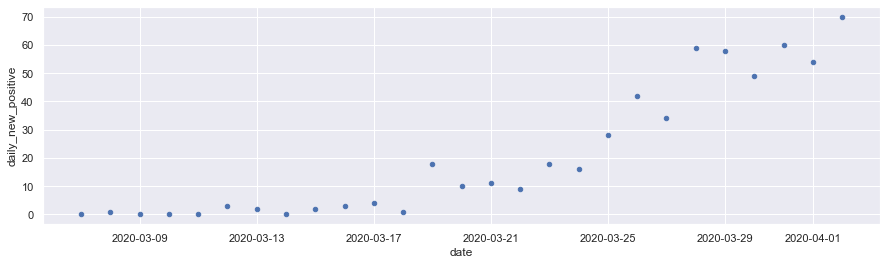

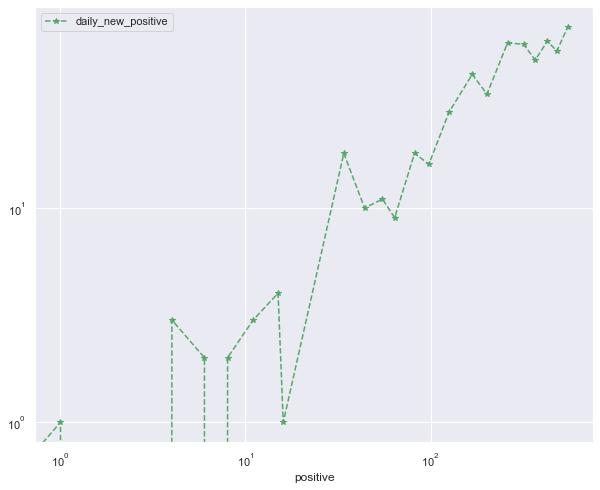

State=NH  (last_update=2020-04-01T09:00)
Doubling every 4.02 days based on last 10 days of data
(naive estimates: current_unresolved=337 hosp=50 icu=13)


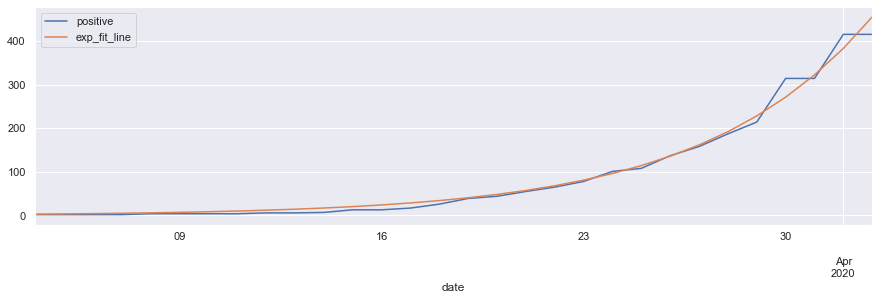

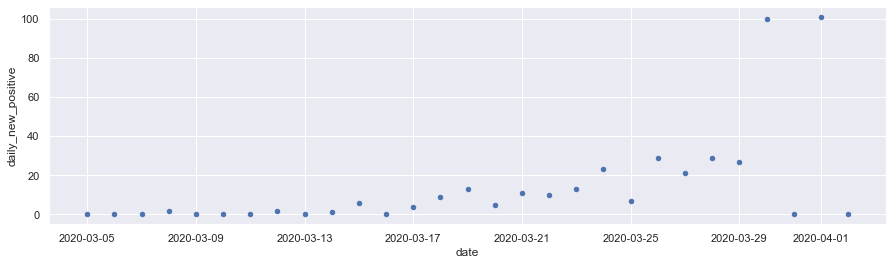

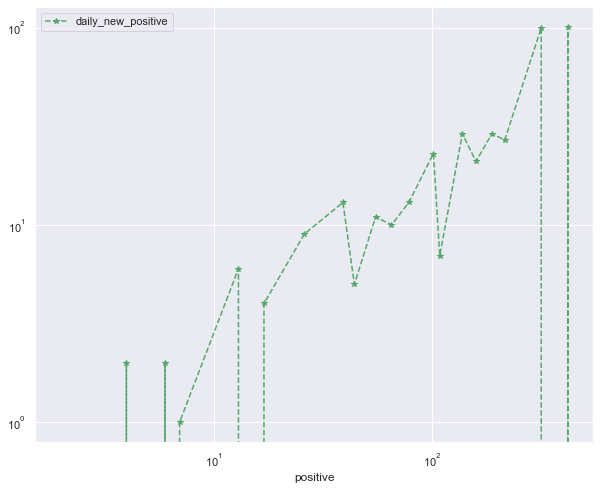

State=DE  (last_update=2020-04-02T16:45)
Doubling every 4.19 days based on last 10 days of data
(naive estimates: current_unresolved=325 hosp=48 icu=13)


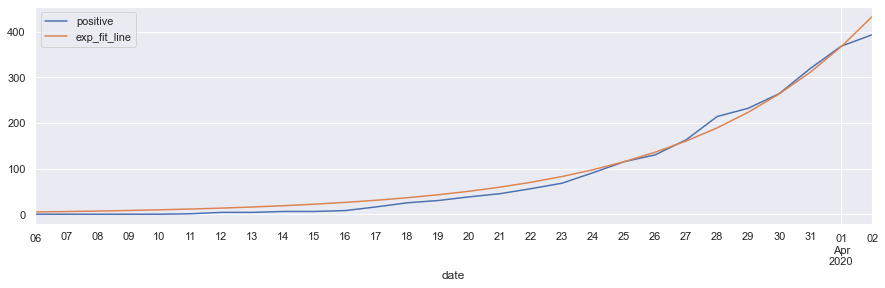

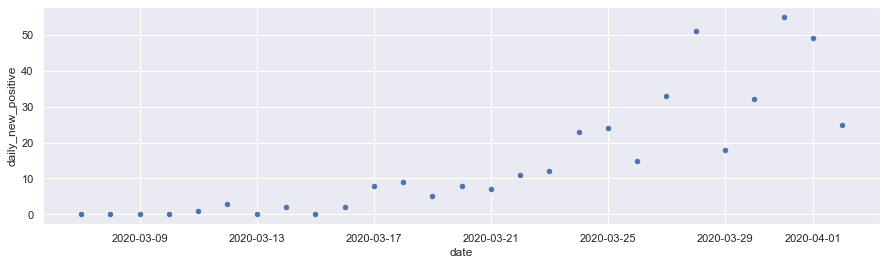

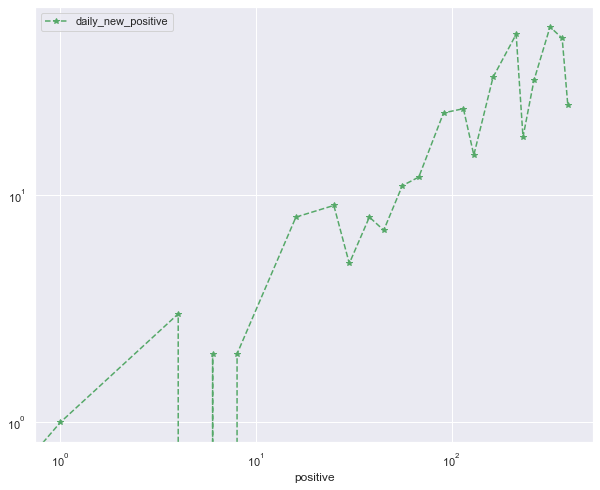

State=ME  (last_update=2020-04-02T10:00)
Doubling every 5.5 days based on last 10 days of data
(naive estimates: current_unresolved=269 hosp=40 icu=10)


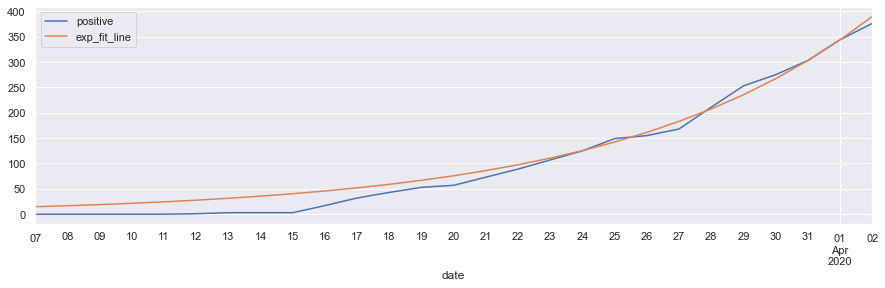

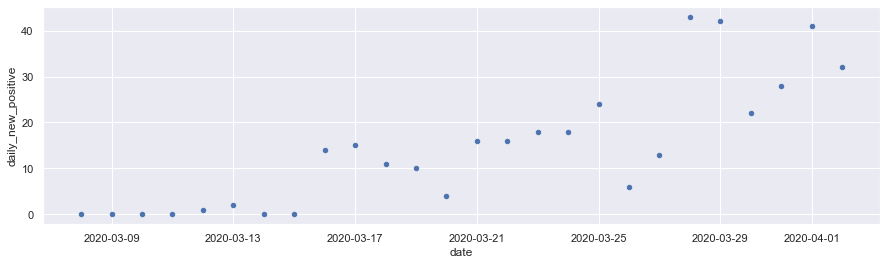

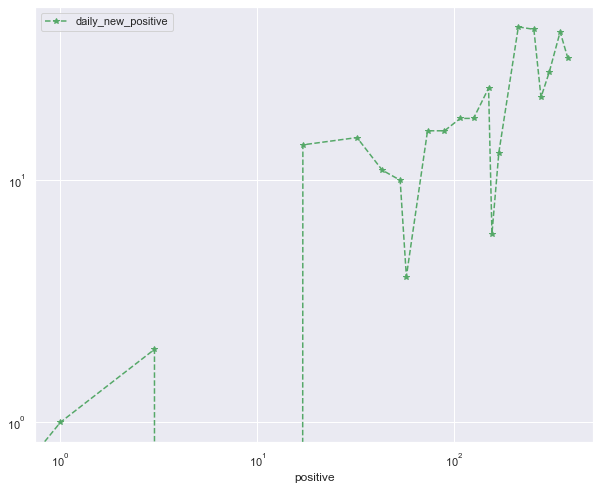

State=NM  (last_update=2020-04-01T00:00)
Doubling every 4.12 days based on last 10 days of data
(naive estimates: current_unresolved=298 hosp=44 icu=11)


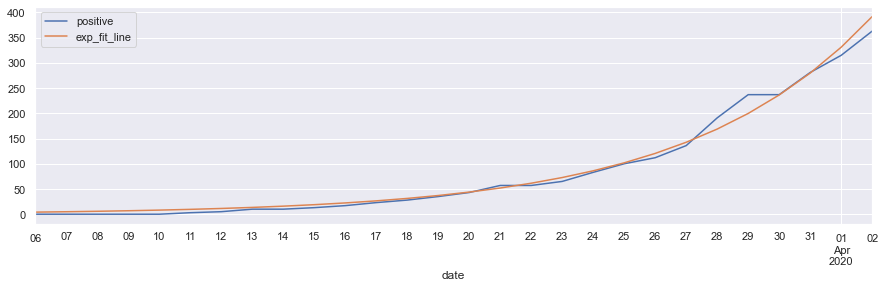

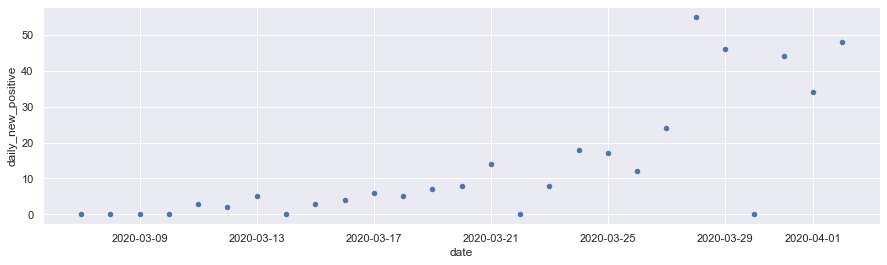

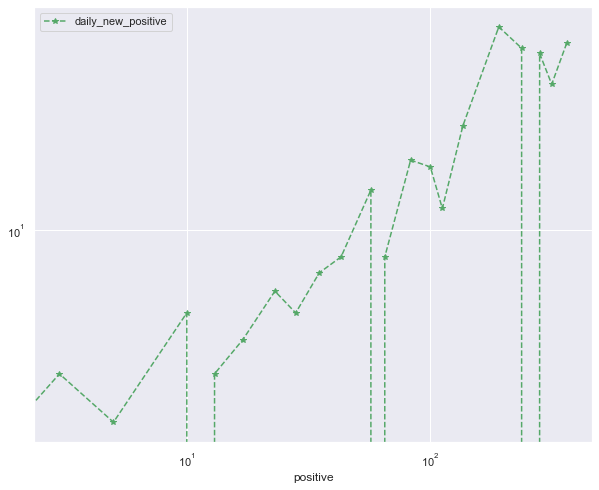

State=VT  (last_update=2020-04-02T13:00)
Doubling every 5.12 days based on last 10 days of data
(naive estimates: current_unresolved=263 hosp=39 icu=10)


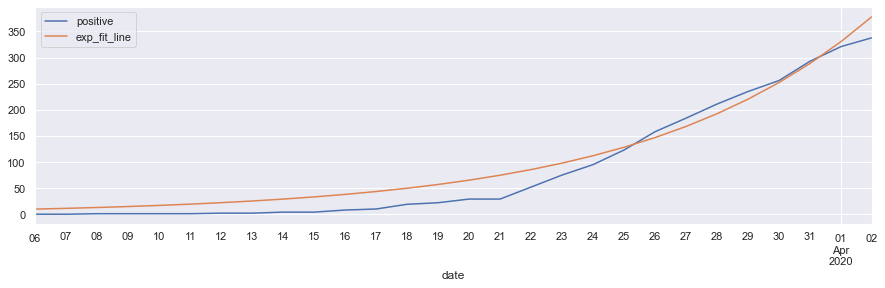

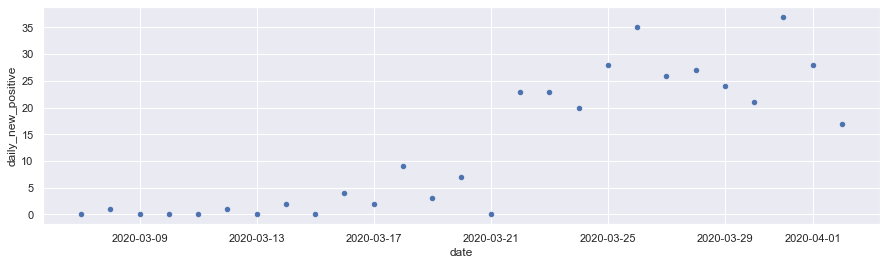

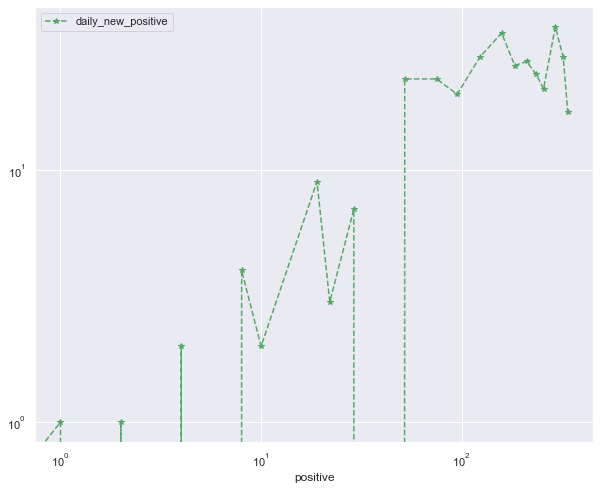

State=PR  (last_update=2020-04-02T07:00)
Doubling every 2.85 days based on last 10 days of data
(naive estimates: current_unresolved=285 hosp=42 icu=11)


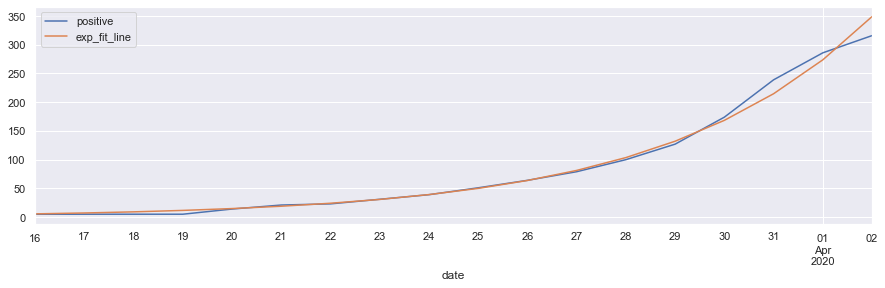

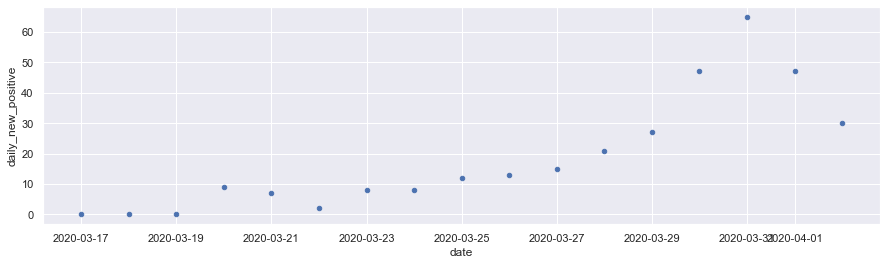

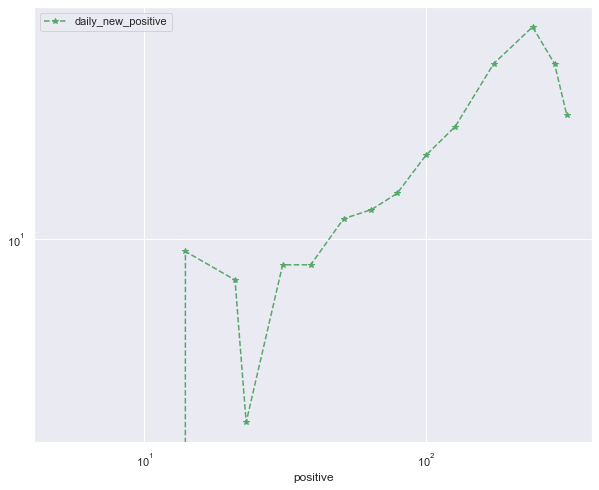

State=HI  (last_update=2020-04-01T18:00)
Doubling every 5.13 days based on last 10 days of data
(naive estimates: current_unresolved=202 hosp=30 icu=8)


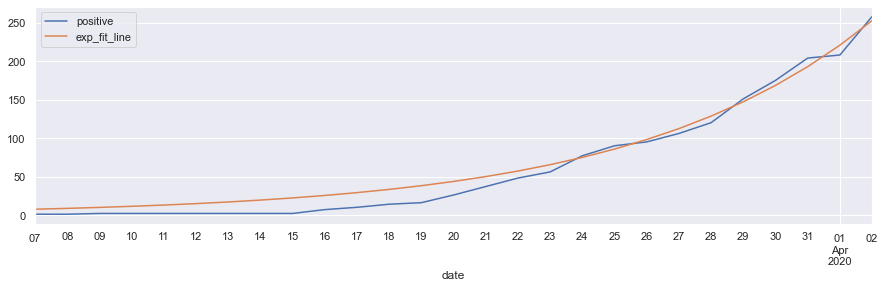

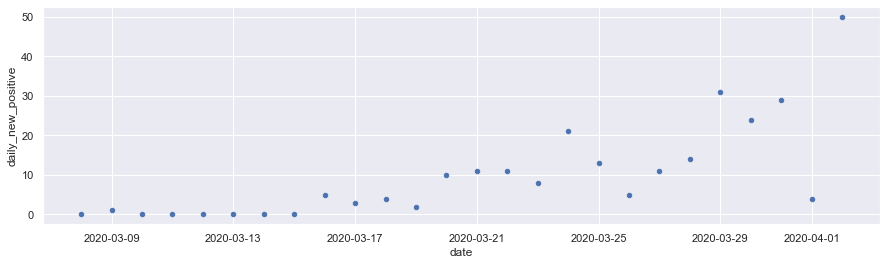

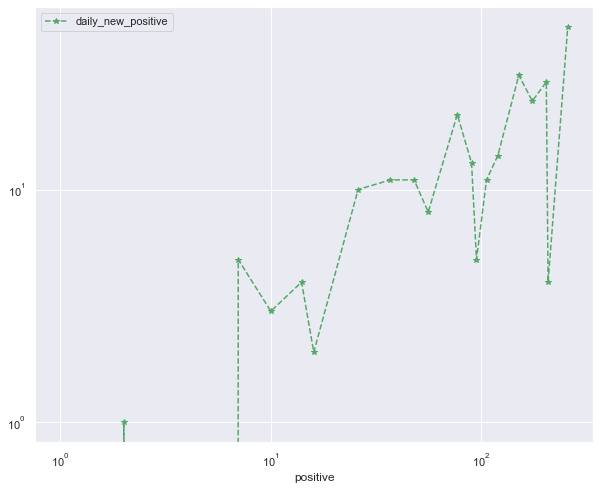

State=NE  (last_update=2020-04-02T14:00)
Doubling every 3.99 days based on last 10 days of data
(naive estimates: current_unresolved=196 hosp=29 icu=7)


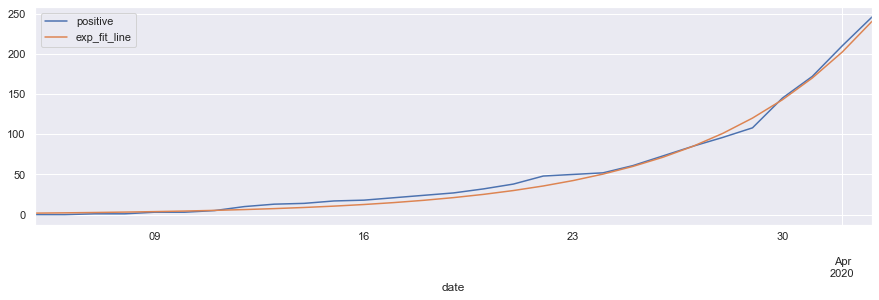

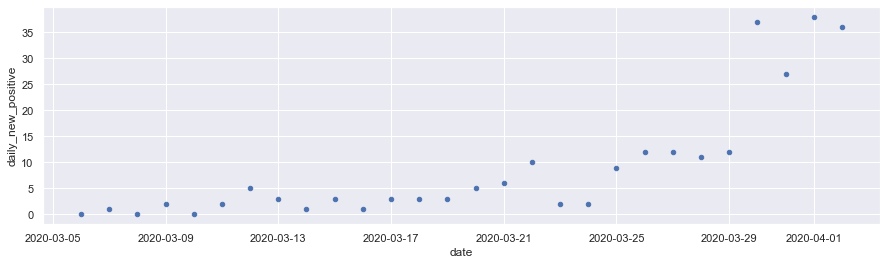

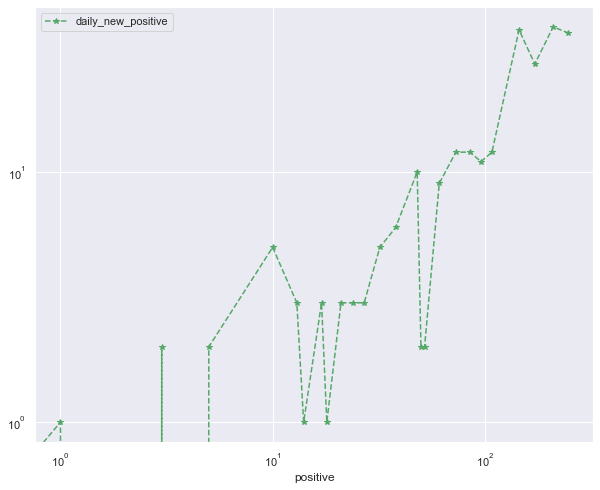

State=MT  (last_update=2020-04-02T10:00)
Doubling every 3.78 days based on last 10 days of data
(naive estimates: current_unresolved=193 hosp=28 icu=7)


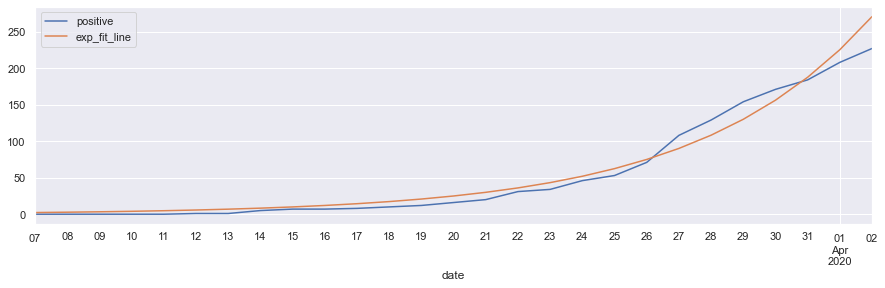

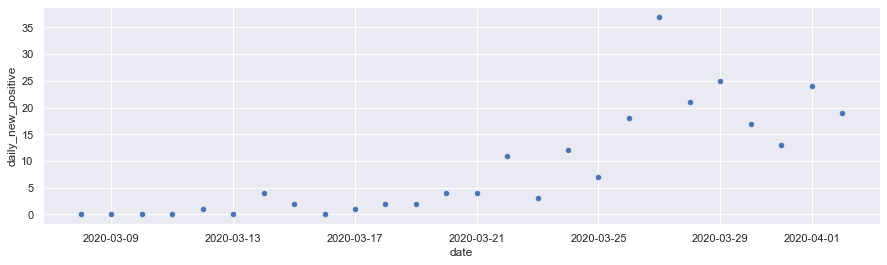

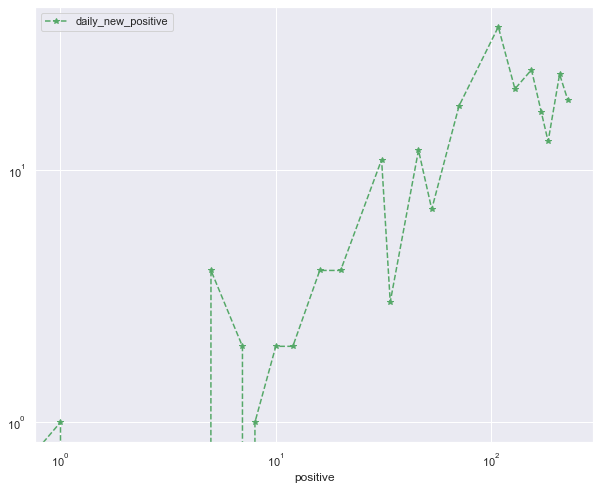

State=WV  (last_update=2020-04-02T00:17)
Doubling every 2.86 days based on last 10 days of data
(naive estimates: current_unresolved=201 hosp=30 icu=8)


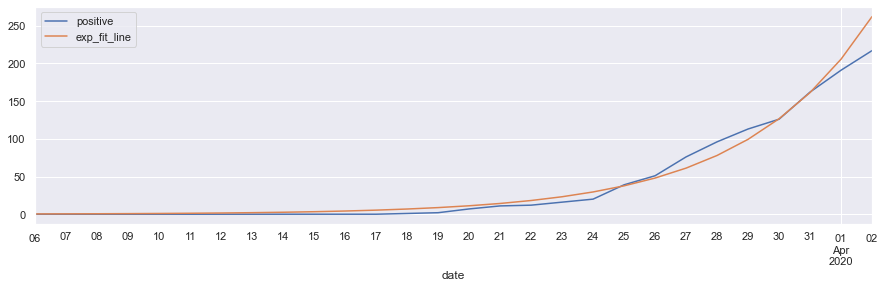

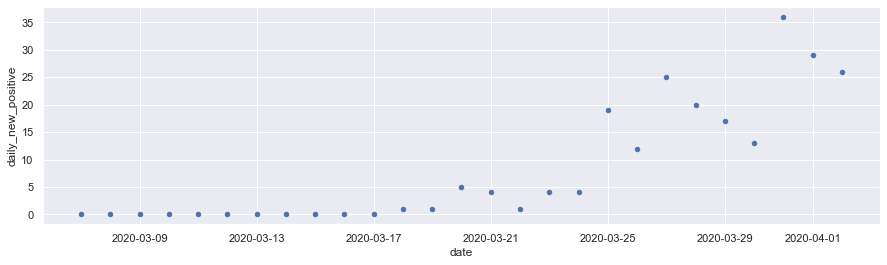

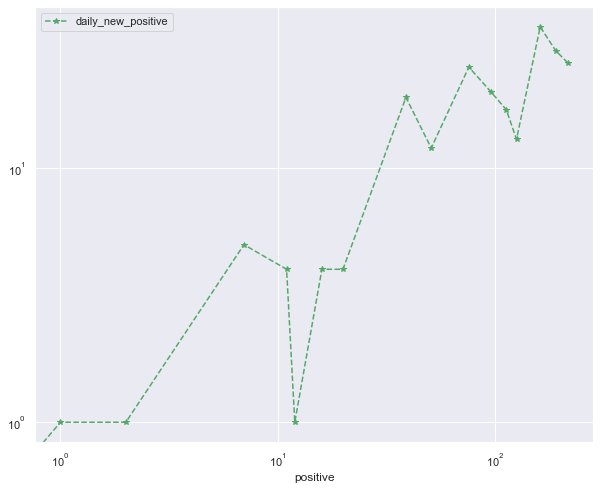

State=SD  (last_update=2020-04-01T18:00)
Doubling every 3.87 days based on last 10 days of data
(naive estimates: current_unresolved=137 hosp=20 icu=5)


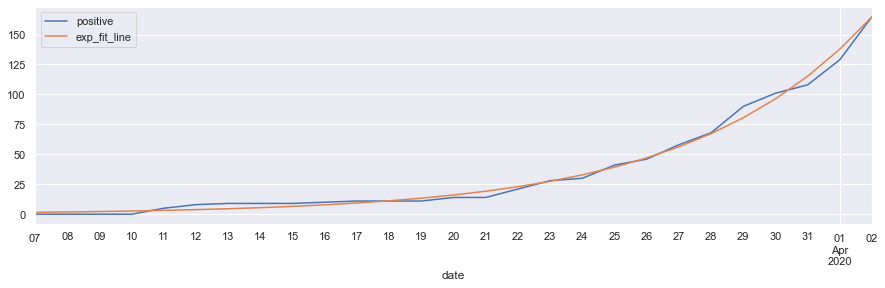

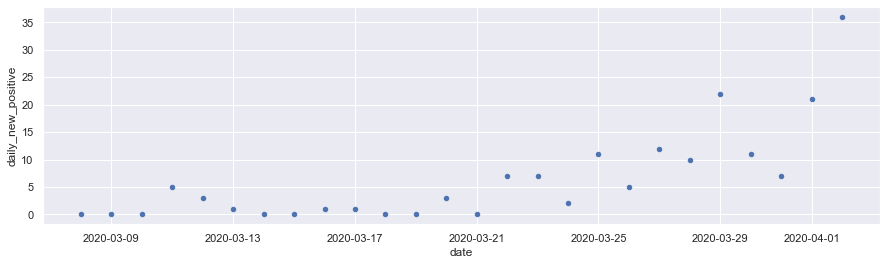

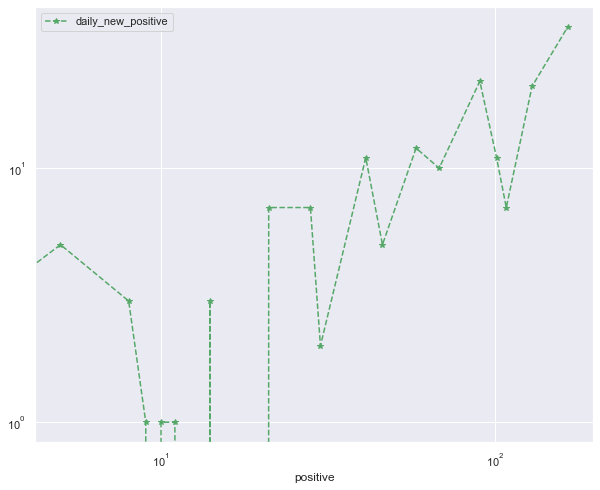

State=ND  (last_update=2020-04-02T12:56)
Doubling every 3.93 days based on last 10 days of data
(naive estimates: current_unresolved=129 hosp=19 icu=5)


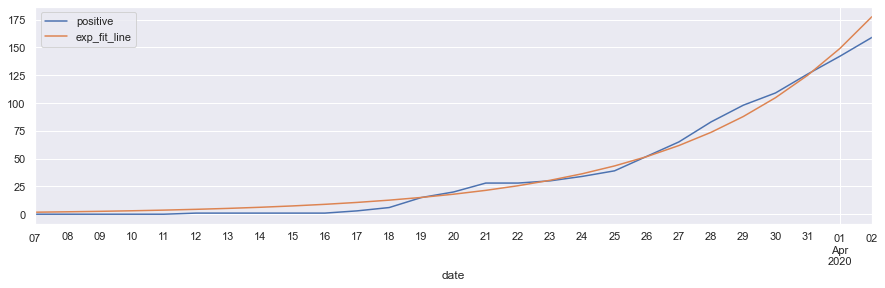

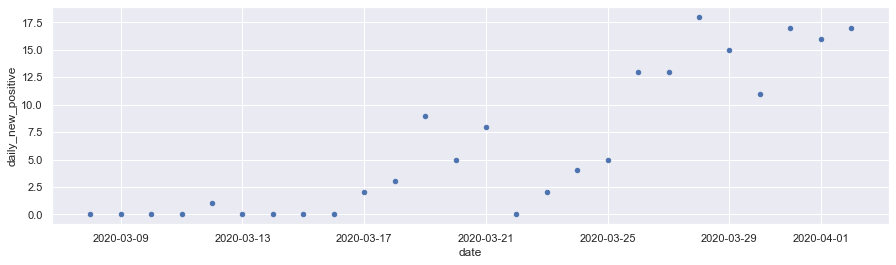

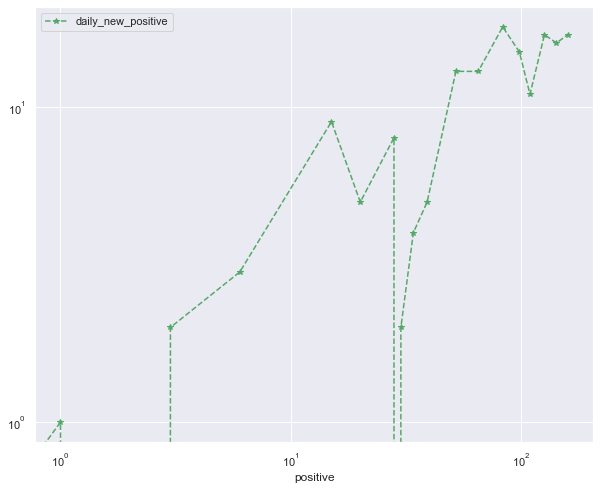

State=WY  (last_update=2020-04-02T10:30)
Doubling every 4.25 days based on last 10 days of data
(naive estimates: current_unresolved=124 hosp=18 icu=4)


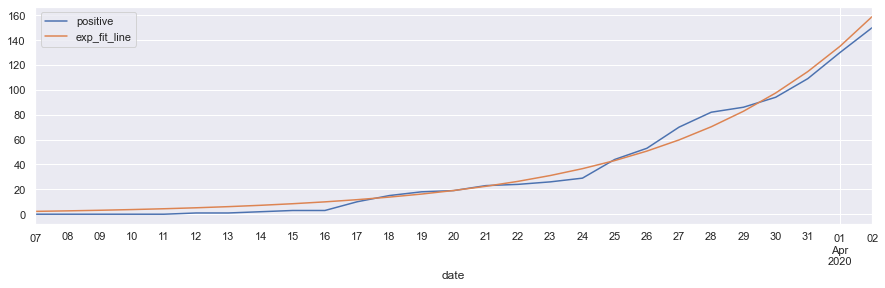

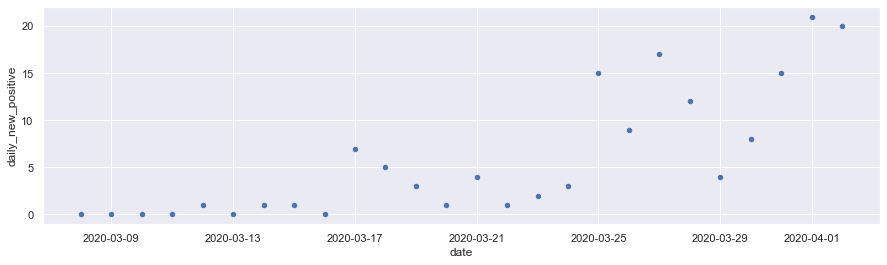

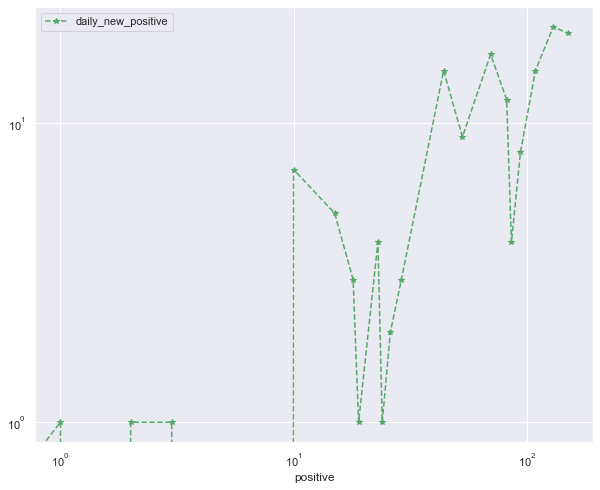

State=AK  (last_update=2020-04-01T21:00)
Doubling every 4.45 days based on last 10 days of data
(naive estimates: current_unresolved=121 hosp=18 icu=4)


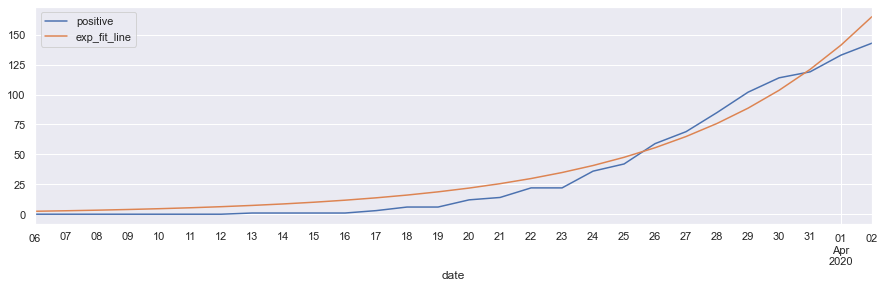

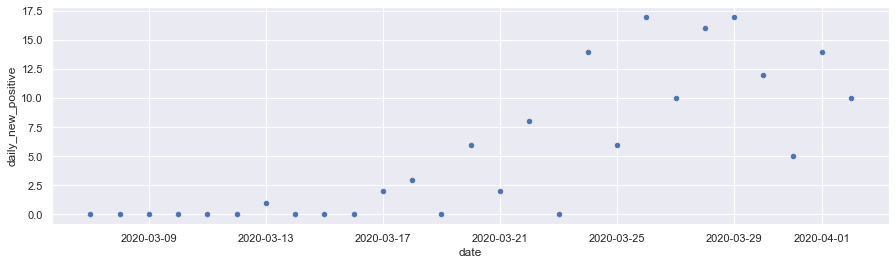

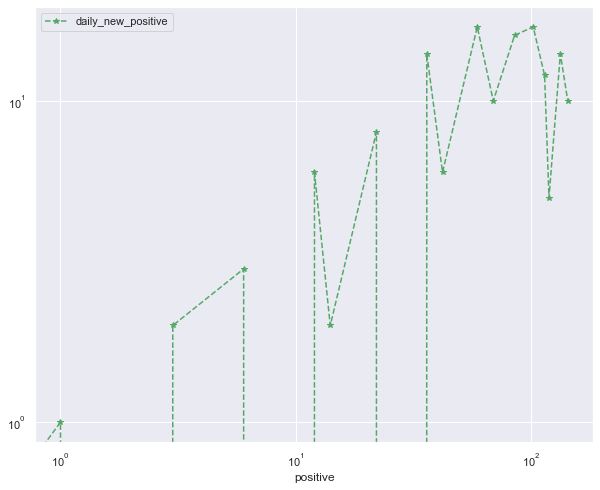

State=GU  (last_update=2020-04-02T08:30)
Doubling every 7.09 days based on last 10 days of data
(naive estimates: current_unresolved=53 hosp=7 icu=2)


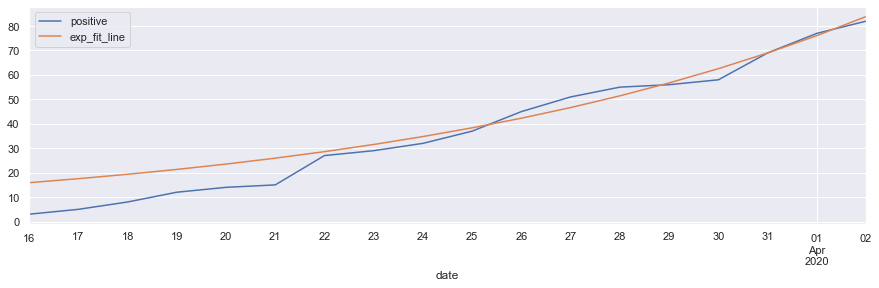

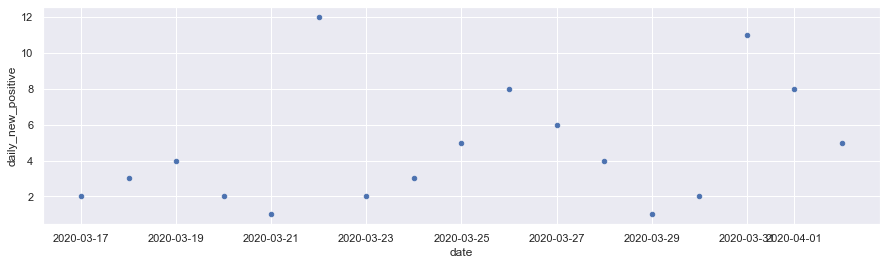

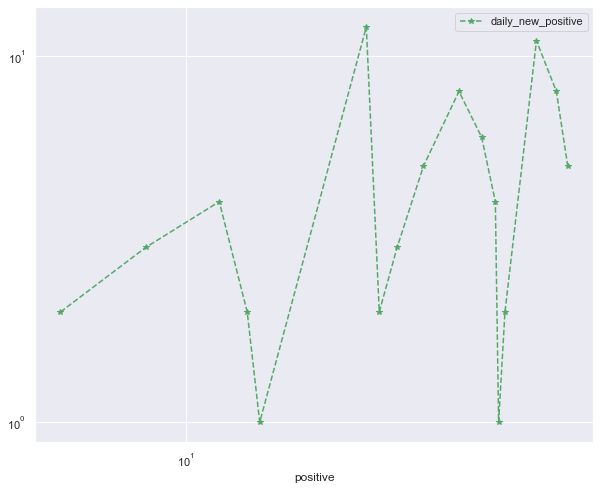

State=VI  (last_update=2020-04-02T09:30)
Doubling every 8.05 days based on last 10 days of data
(naive estimates: current_unresolved=16 hosp=2 icu=0)


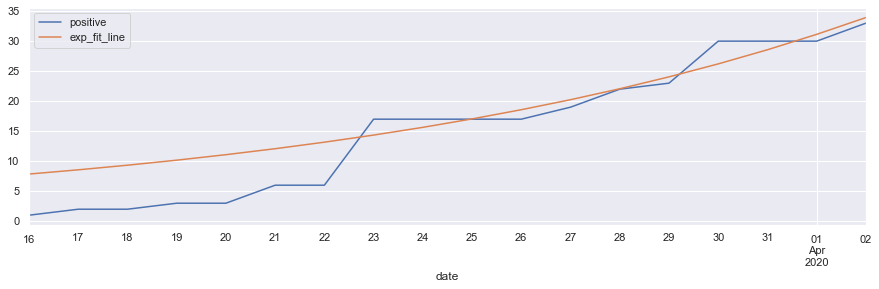

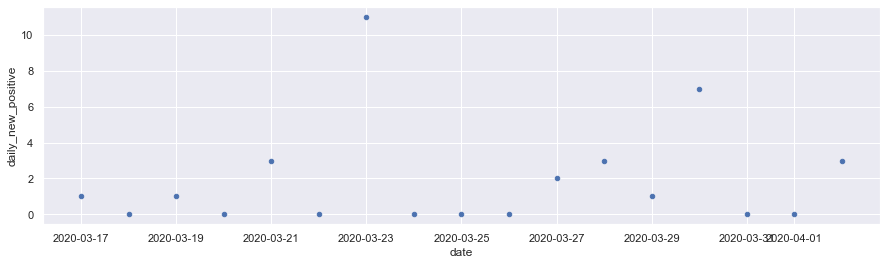

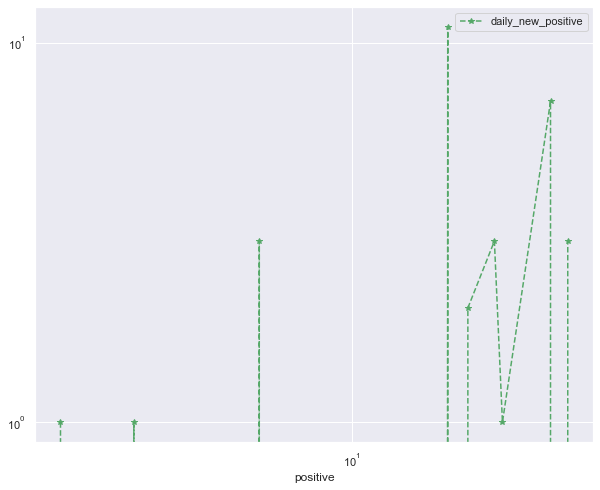

State=MP  (last_update=2020-04-02T03:00)
Doubling every 2.37 days based on last 10 days of data
(naive estimates: current_unresolved=8 hosp=1 icu=0)


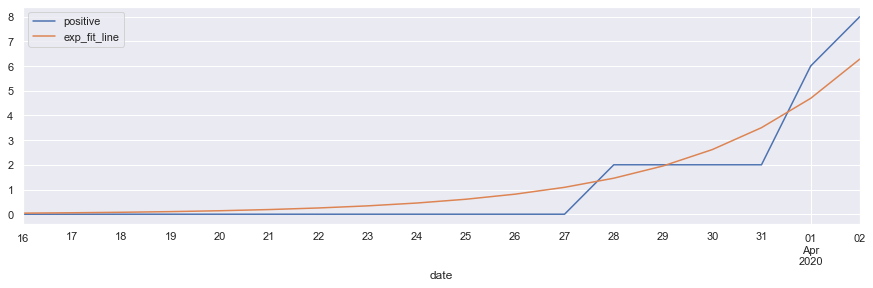

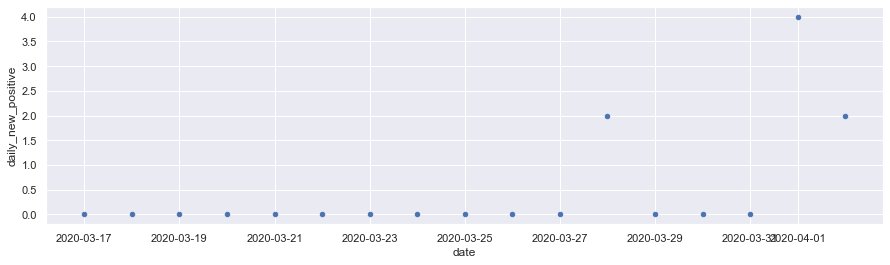

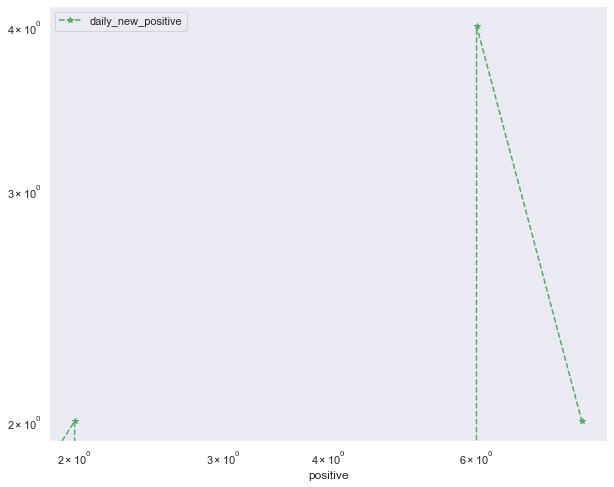

State=AS  (last_update=2020-03-30T23:00)
Doubling every nan days based on last 10 days of data
(naive estimates: current_unresolved=0 hosp=0 icu=0)


/Users/drskippy/Library/Caches/pypoetry/virtualenvs/covid19-r4Mn4VDy-py3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:520: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  labels = axis.get_majorticklabels() + axis.get_minorticklabels()


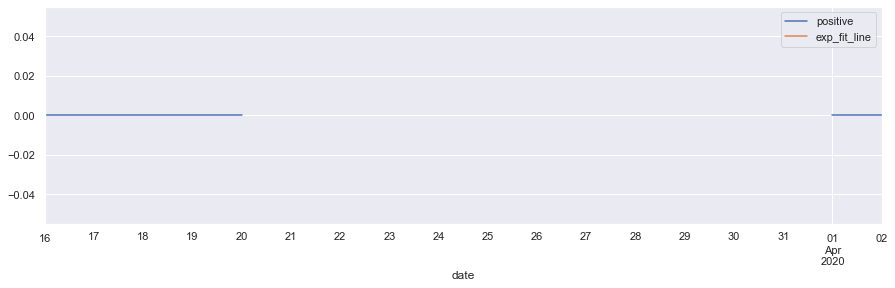

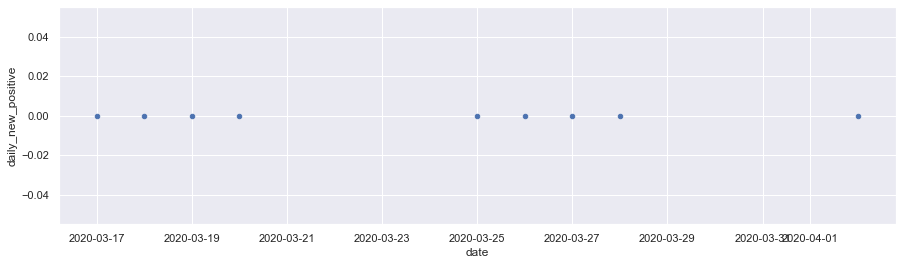

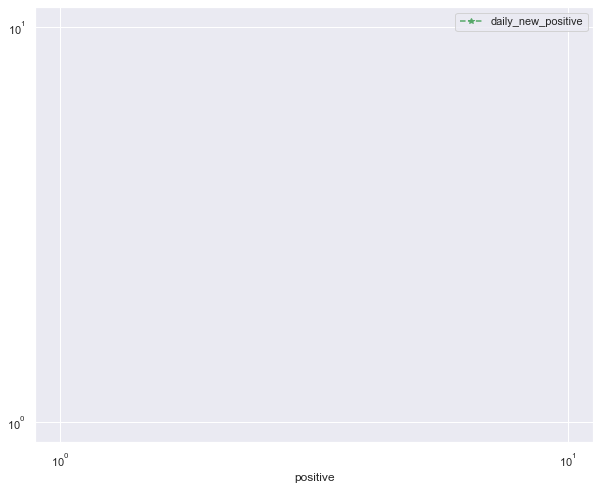

In [14]:
last_n_days = 10
dps = []
for s in states_in_order:
    dfq, dt, lud = get_state_doubling_df(df, s, use_last_n_days=last_n_days)
    dps.append(dt)
    cn, cnh, cni = estimate_current_cases(dfq.daily_new_positive.values)
    lu = str(lud)[:16]
    print("State={}  (last_update={})".format(s, lu))
    print("Doubling every {:.3} days based on last {} days of data".format(dt, last_n_days))
    print("(naive estimates: current_unresolved={} hosp={} icu={})".format(cn, cnh, cni))
    dfq.plot(x="date", y=["positive", "exp_fit_line"], figsize=[15,4])
    if len(dfq) > 1:
        dfq.plot.scatter(x="date", y="daily_new_positive", figsize=[15,4])
    dfq.plot(x="positive", y="daily_new_positive", figsize=[10,8], style="*--g", logy=True, logx=True)
    plt.show()

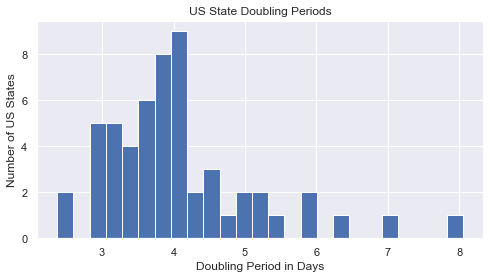

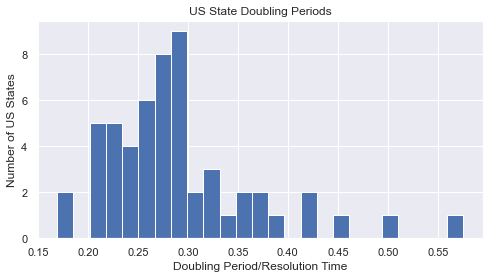

In [15]:
plt.figure(figsize=[8,4])
dps = np.array(dps)
dps = dps[~np.isnan(dps)]
dp_state = dps[dps < 30]
dp_state = dp_state[dp_state > 0]
a = plt.hist(dp_state, bins=25)
plt.title("US State Doubling Periods")
plt.xlabel("Doubling Period in Days")
plt.ylabel("Number of US States")
plt.show()
# or in terms of resolution time
plt.figure(figsize=[8,4])
resolution_time = 14
a = plt.hist(dp_state/resolution_time, bins=25)
plt.title("US State Doubling Periods")
plt.xlabel("Doubling Period/Resolution Time")
plt.ylabel("Number of US States")
plt.show()

### Rolling Doubling Period for US

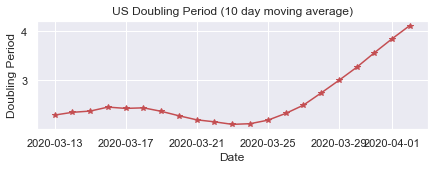

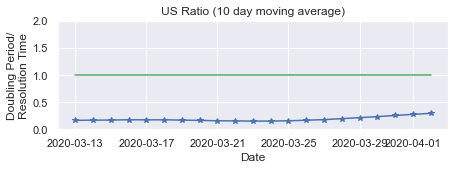

In [16]:
window_size = 10 # days
start_date, end_date = df.date.min(), df.date.max()
delta_t = pd.Timedelta(days=1)
days = int((end_date - start_date).days)
dtv = []
dtt = []
for i in range(days-window_size+2):
    sdt = start_date + i * delta_t
    edt = sdt + window_size * delta_t
    _df = df.loc[(df.date >= sdt) & (df.date < edt)].copy()
    dfa, dt, lud = get_state_doubling_df(_df, "*", use_last_n_days=window_size)
    dtv.append(dt)
    dtt.append(_df.date.values[-1])
plt.figure(figsize=[7,2])
plt.plot(dtt, dtv, "*r-")
plt.title("US Doubling Period ({} day moving average)".format(window_size))
plt.ylabel("Doubling Period")
plt.xlabel("Date")
plt.show()
# by ratio
plt.figure(figsize=[7,2])
plt.plot(dtt, np.array(dtv)/resolution_time, "*b-")
plt.plot(dtt, np.ones(len(dtt)), "g")
plt.title("US Ratio ({} day moving average)".format(window_size))
plt.ylim((0,2))
plt.ylabel("Doubling Period/\nResolution Time")
plt.xlabel("Date")
plt.show()

### Rolling Doubling Period World

In [17]:
dfw, wsl = get_world_dataset_df_from_file()
dfw.head()

Entity state          Date  positive       date  \
0  Afghanistan   AFG  Dec 31, 2019         0 2019-12-31   
1  Afghanistan   AFG   Jan 1, 2020         0 2020-01-01   
2  Afghanistan   AFG   Jan 2, 2020         0 2020-01-02   
3  Afghanistan   AFG   Jan 3, 2020         0 2020-01-03   
4  Afghanistan   AFG   Jan 4, 2020         0 2020-01-04   

                lastUpdateEt  negative  pending  
0 2020-04-03 03:47:02.879917         0        0  
1 2020-04-03 03:47:02.879917         0        0  
2 2020-04-03 03:47:02.879917         0        0  
3 2020-04-03 03:47:02.879917         0        0  
4 2020-04-03 03:47:02.879917         0        0

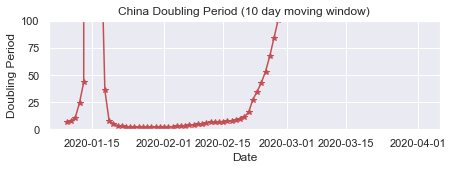

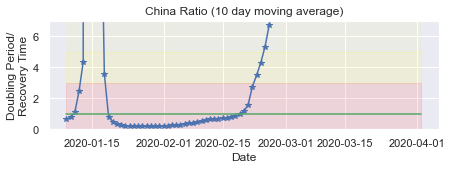

/Users/drskippy/Working/2020covid19/covid_analysis/models.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  return -np.log(.5)/m, fit_line_points


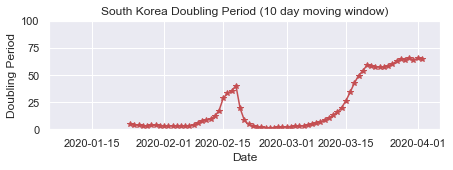

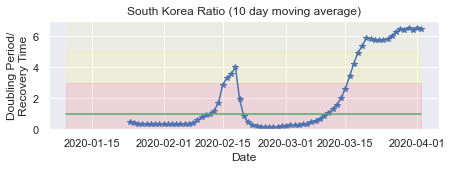

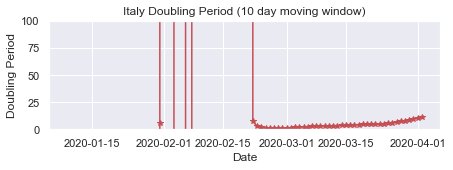

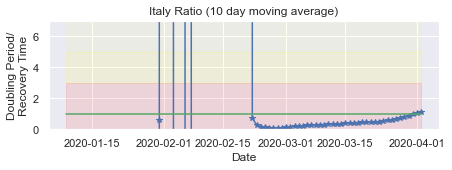

/Users/drskippy/Working/2020covid19/covid_analysis/models.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  return -np.log(.5)/m, fit_line_points


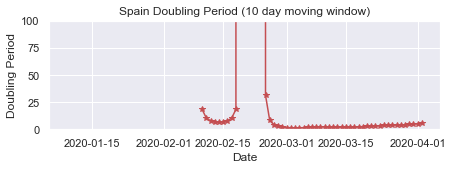

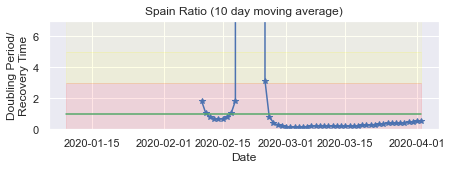

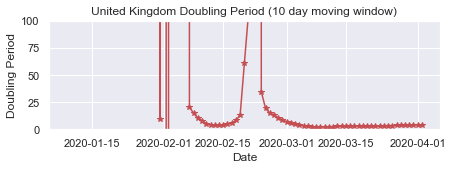

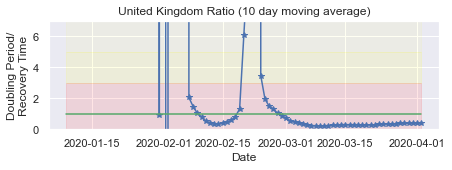

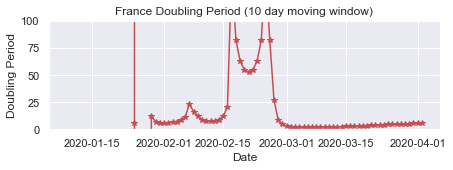

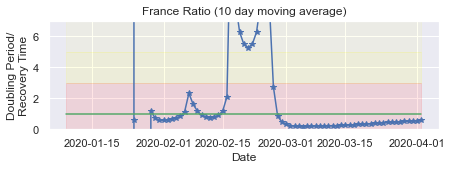

/Users/drskippy/Working/2020covid19/covid_analysis/models.py:72: RuntimeWarning: divide by zero encountered in double_scalars
  return -np.log(.5)/m, fit_line_points


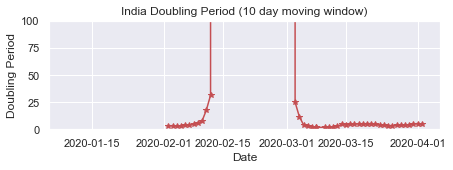

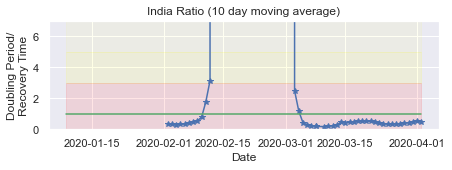

In [18]:
period_factor_plot(dfw,"CHN")
period_factor_plot(dfw,"KOR")
period_factor_plot(dfw,"ITA")
period_factor_plot(dfw,"ESP")
period_factor_plot(dfw,"GBR")
period_factor_plot(dfw,"FRA")
period_factor_plot(dfw,"IND")

### Rolling Doubling Period States

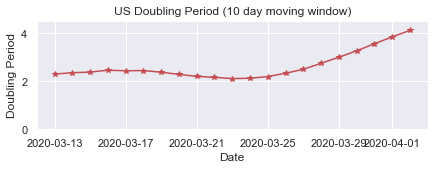

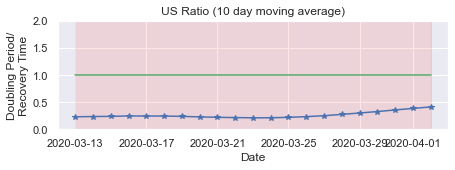

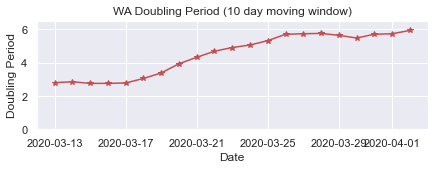

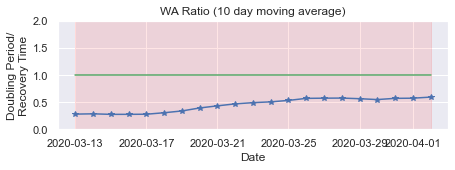

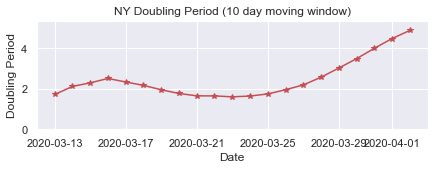

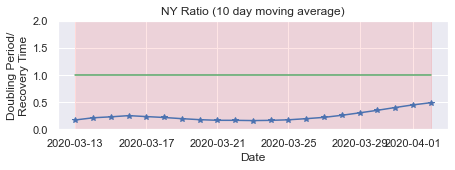

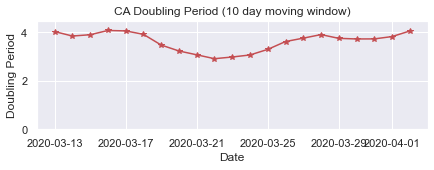

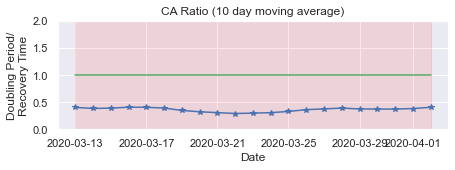

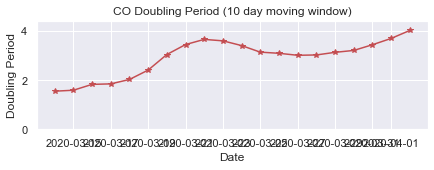

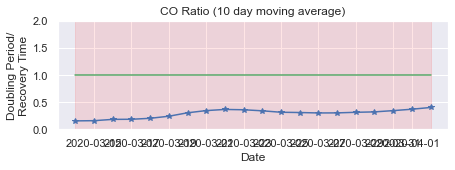

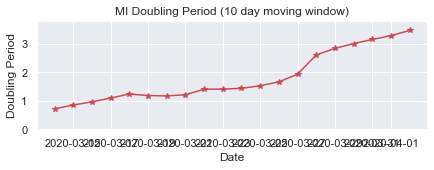

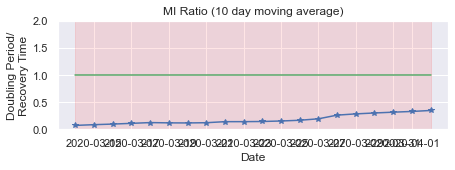

In [19]:
dfw, _ = get_state_df(df, "*")
period_factor_plot(dfw,"*", ylimit=2)
dfw, _ = get_state_df(df, "WA")
period_factor_plot(dfw,"WA", ylimit=2)
dfw, _ = get_state_df(df, "NY")
period_factor_plot(dfw,"NY", ylimit=2)
dfw, _ = get_state_df(df, "CA")
period_factor_plot(dfw,"CA", ylimit=2)
dfw, _ = get_state_df(df, "CO")
period_factor_plot(dfw,"CO", ylimit=2)
dfw, _ = get_state_df(df, "MI")
period_factor_plot(dfw,"MI", ylimit=2)

### Big Grid of Daily Total Cases by State

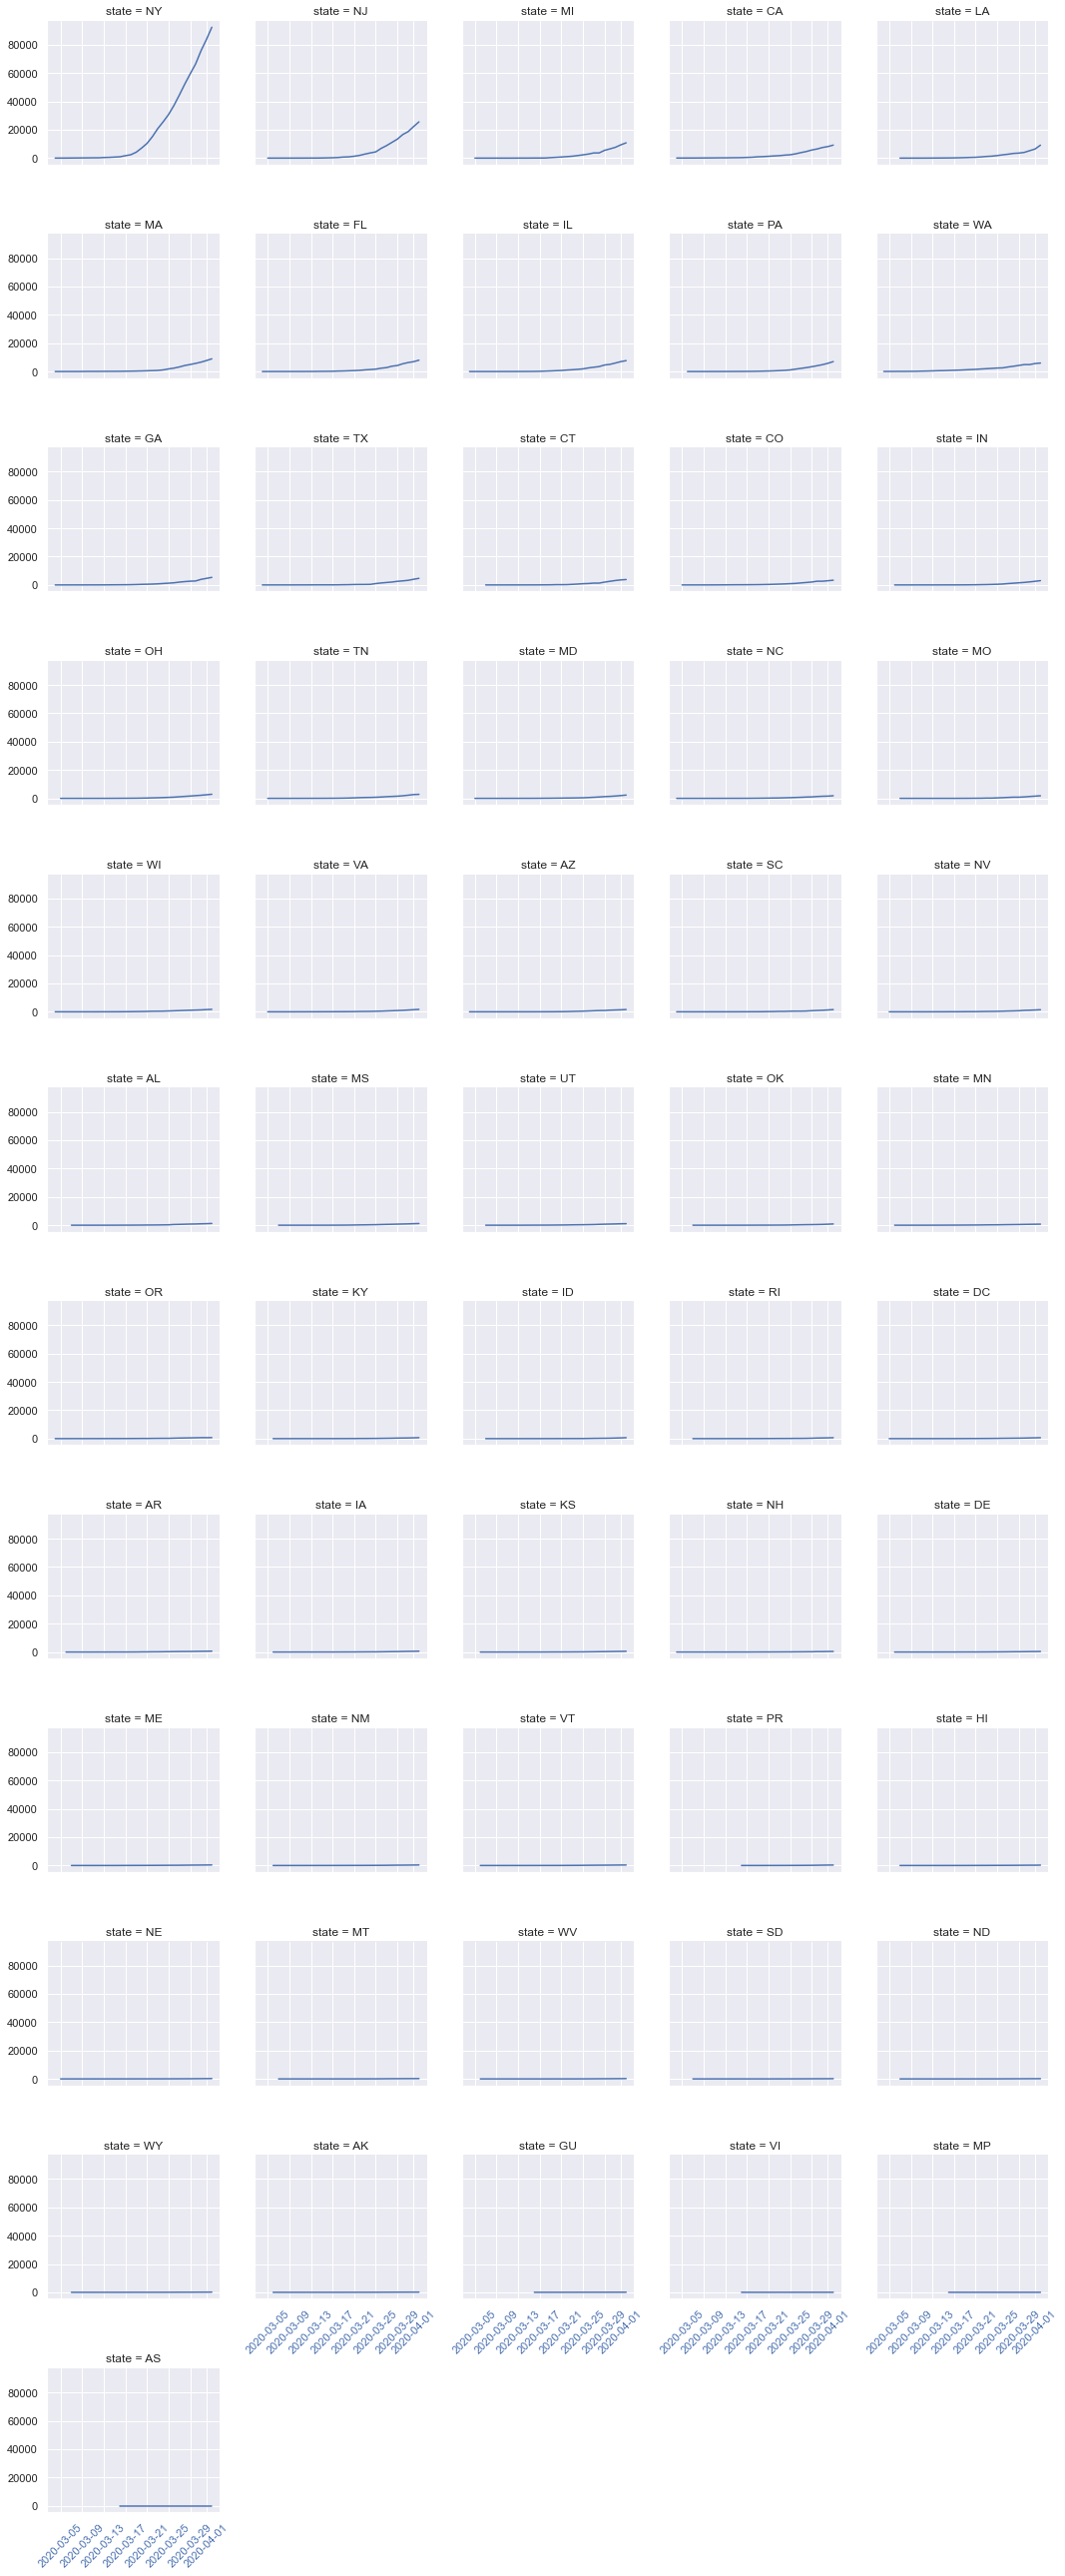

In [20]:
g = sns.FacetGrid(df, col="state", col_wrap=5, height=3, margin_titles=True)
g.map(plt.plot,"date","positive",color="b")
g.map(plt.xticks, rotation=45)